In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True


Mounted at /content/drive


In [2]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Recipes and Reviews"

reviews = pd.read_parquet(f"{DATA_DIR}/reviews.parquet")
recipes = pd.read_parquet(f"{DATA_DIR}/recipes.parquet")

print("reviews shape:", reviews.shape)
print("recipes shape:", recipes.shape)
print("Reviews columns:", reviews.columns.tolist())
print("Recipes columns:", recipes.columns.tolist())


reviews shape: (1401982, 8)
recipes shape: (522517, 28)
Reviews columns: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified']
Recipes columns: ['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']


In [3]:
recipe_counts = reviews["RecipeId"].value_counts()
valid_recipes = recipe_counts[recipe_counts >= 20].index
reviews_f = reviews[reviews["RecipeId"].isin(valid_recipes)]

user_counts = reviews_f["AuthorId"].value_counts()
valid_users = user_counts[user_counts >= 20].index
reviews_f = reviews_f[reviews_f["AuthorId"].isin(valid_users)]

print("Filtered reviews shape:", reviews_f.shape)
print("Unique recipes:", reviews_f["RecipeId"].nunique())
print("Unique users:", reviews_f["AuthorId"].nunique())


Filtered reviews shape: (276559, 8)
Unique recipes: 10268
Unique users: 4416


In [4]:
recipes_small = recipes[[
    "RecipeId", "Name", "Description", "RecipeCategory",
    "Keywords", "RecipeIngredientParts"
]].drop_duplicates("RecipeId")

def safe_text(x):
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    if isinstance(x, (list, tuple, np.ndarray)):
        parts = []
        for v in x:
            if v is None:
                continue
            if isinstance(v, float) and np.isnan(v):
                continue
            parts.append(str(v))
        return " ".join(parts)
    return str(x)

recipes_small["meta_text"] = (
      recipes_small["Name"].apply(safe_text) + " "
    + recipes_small["Description"].apply(safe_text) + " "
    + recipes_small["RecipeCategory"].apply(safe_text) + " "
    + recipes_small["Keywords"].apply(safe_text) + " "
    + recipes_small["RecipeIngredientParts"].apply(safe_text)
)

print("recipes_small shape:", recipes_small.shape)
print("Sample meta_text:", recipes_small["meta_text"].iloc[0][:200])


recipes_small shape: (522517, 7)
Sample meta_text: Low-Fat Berry Blue Frozen Dessert Make and share this Low-Fat Berry Blue Frozen Dessert recipe from Food.com. Frozen Desserts Dessert Low Protein Low Cholesterol Healthy Free Of... Summer Weeknight Fr


In [5]:
data = reviews_f.merge(
    recipes_small[["RecipeId", "meta_text"]],
    on="RecipeId",
    how="inner"
)

data = data.dropna(subset=["Rating"]).reset_index(drop=True)

print("Final merged data shape:", data.shape)
data.head()


Final merged data shape: (276559, 9)


,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,meta_text
0,243,810,2312,Gay Gilmore,0,"Good, but I wished they were a bit more moist.",2001-01-02 16:15:26+00:00,2001-01-02 16:15:26+00:00,Irresistible Peanut Butter Cookies Make and sh...
1,292,5466,2312,Gay Gilmore,1,"I'm pretty sure this recipe is a joke, but I d...",2001-01-16 10:53:59+00:00,2001-01-16 10:53:59+00:00,Twinkie Del Mar The creation of John Mansfield...
2,526,8600,2312,Gay Gilmore,4,"Fancy macaroni and cheese, so you don't have t...",2001-03-13 19:51:36+00:00,2001-03-13 19:51:36+00:00,Cheese Stuffed Shells Make and share this Chee...
3,700,2886,2312,Gay Gilmore,5,I used one more banana than called for because...,2001-04-18 08:53:27+00:00,2001-04-18 08:53:27+00:00,Best Banana Bread Make and share this Best Ban...
4,741,5466,8526,KissMyTiara,1,This really made me laugh after having a bad d...,2001-04-24 16:07:29+00:00,2001-04-24 16:07:29+00:00,Twinkie Del Mar The creation of John Mansfield...


In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data[["AuthorId", "RecipeId", "Rating", "meta_text"]],
    test_size=0.2,
    random_state=42
)

print("Train:", train_df.shape)
print("Test:", test_df.shape)


Train: (221247, 4)
Test: (55312, 4)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

unique_users = np.sort(data["AuthorId"].unique())
unique_items = np.sort(data["RecipeId"].unique())

user_id_to_idx = {u: i for i, u in enumerate(unique_users)}
item_id_to_idx = {m: i for i, m in enumerate(unique_items)}

n_users = len(unique_users)
n_items = len(unique_items)

print("n_users:", n_users, " n_items:", n_items)

recipes_for_tfidf = recipes_small.set_index("RecipeId").loc[unique_items]["meta_text"].fillna("")
texts = recipes_for_tfidf.values

tfidf = TfidfVectorizer(stop_words="english", max_features=40000)
tfidf_matrix = tfidf.fit_transform(texts)
print("TF-IDF shape:", tfidf_matrix.shape)


n_users: 4416  n_items: 10268
TF-IDF shape: (10268, 13915)


In [8]:
TOP_K = 200
BATCH = 2000

item_sim_indices = np.zeros((n_items, TOP_K), dtype=np.int32)
item_sim_scores  = np.zeros((n_items, TOP_K), dtype=np.float32)

for start in range(0, n_items, BATCH):
    end = min(start + BATCH, n_items)
    sims = cosine_similarity(tfidf_matrix[start:end], tfidf_matrix)
    for i in range(end - start):
        sims[i, start + i] = 0.0

    topk_idx = np.argpartition(-sims, TOP_K, axis=1)[:, :TOP_K]

    for i in range(end - start):
        idxs = topk_idx[i]
        scores = sims[i, idxs]
        order = np.argsort(-scores)
        item_sim_indices[start + i] = idxs[order]
        item_sim_scores[start + i]  = scores[order]

print("Top-K item similarities computed.")


Top-K item similarities computed.


In [9]:
global_mean = train_df["Rating"].mean()

user_rated_items = {u: [] for u in unique_users}
for row in train_df.itertuples(index=False):
    user_rated_items[row.AuthorId].append((row.RecipeId, row.Rating))

def predict_cbf_for_pair(user_id, recipe_id):
    rated = user_rated_items.get(user_id, [])
    if not rated:
        return global_mean

    if recipe_id not in item_id_to_idx:
        rs = np.array([r for _, r in rated])
        return rs.mean() if len(rs) > 0 else global_mean

    target_idx = item_id_to_idx[recipe_id]
    neighbors = item_sim_indices[target_idx]
    sims      = item_sim_scores[target_idx]

    used_ratings = []
    used_sims    = []

    for rid, r in rated:
        if rid in item_id_to_idx:
            j = item_id_to_idx[rid]
            hits = np.where(neighbors == j)[0]
            if len(hits) > 0:
                used_ratings.append(r)
                used_sims.append(sims[hits[0]])

    if len(used_ratings) == 0:
        rs = np.array([r for _, r in rated])
        return rs.mean() if len(rs) > 0 else global_mean

    used_ratings = np.array(used_ratings)
    used_sims    = np.array(used_sims)

    return np.sum(used_sims * used_ratings) / np.sum(used_sims)

def predict_cbf(df):
    return np.array([predict_cbf_for_pair(r.AuthorId, r.RecipeId) for r in df.itertuples(index=False)])

print("CBF sanity check:", predict_cbf(train_df.head()))


CBF sanity check: [4.53333333 4.99999975 5.         3.63407304 4.97727273]


In [10]:
R_dense = np.zeros((n_users, n_items), dtype=np.float32)
for row in train_df.itertuples(index=False):
    u = user_id_to_idx[row.AuthorId]
    i = item_id_to_idx[row.RecipeId]
    R_dense[u, i] = row.Rating

counts = (R_dense > 0).sum(axis=1)
sums   = R_dense.sum(axis=1)

user_means = np.divide(
    sums,
    counts,
    out=np.full_like(sums, global_mean, dtype=float),
    where=counts != 0
)

R_centered = R_dense - user_means[:, None]
R_centered[R_dense == 0] = 0.0

from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(R_centered)
np.fill_diagonal(user_sim, 0.0)

print("user_sim shape:", user_sim.shape)


user_sim shape: (4416, 4416)


In [11]:
def predict_cf_for_pair(user_id, recipe_id, k=50):
    if user_id not in user_id_to_idx or recipe_id not in item_id_to_idx:
        return global_mean

    u = user_id_to_idx[user_id]
    i = item_id_to_idx[recipe_id]

    users_who_rated = R_dense[:, i] > 0
    if not users_who_rated.any():
        return user_means[u]

    sims = user_sim[u, users_who_rated]
    ratings = R_dense[users_who_rated, i]

    if np.all(sims == 0):
        return user_means[u]

    order = np.argsort(-sims)[:k]
    sims_k = sims[order]
    ratings_k = ratings[order]

    denom = np.sum(np.abs(sims_k))
    if denom == 0:
        return user_means[u]

    return user_means[u] + np.sum(sims_k * (ratings_k - user_means[u])) / denom

def predict_cf(df):
    return np.array([predict_cf_for_pair(r.AuthorId, r.RecipeId) for r in df.itertuples(index=False)])

print("CF sanity check:", predict_cf(train_df.head()))


CF sanity check: [3.90978115 2.74895065 1.09852446 4.39365548 5.02323053]


In [12]:
print("Predicting CBF...")
cbf_train = predict_cbf(train_df)
cbf_test  = predict_cbf(test_df)

print("Predicting CF...")
cf_train = predict_cf(train_df)
cf_test  = predict_cf(test_df)

print("Building Hybrid...")
alpha = 0.5
hy_train = alpha * cbf_train + (1 - alpha) * cf_train
hy_test  = alpha * cbf_test  + (1 - alpha) * cf_test


Predicting CBF...
Predicting CF...
Building Hybrid...


In [13]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def fcp(df, preds):
    df = df.copy()
    df["pred"] = preds
    total = 0
    concord = 0
    for uid, group in df.groupby("AuthorId"):
        if len(group) < 2:
            continue
        r = group["Rating"].values
        p = group["pred"].values
        n = len(r)
        for i in range(n):
            for j in range(i+1, n):
                if r[i] == r[j]:
                    continue
                total += 1
                if (r[i]-r[j]) * (p[i]-p[j]) > 0:
                    concord += 1
    return concord / total if total > 0 else 0

# RMSE
cbf_rmse_train = rmse(train_df["Rating"].values, cbf_train)
cbf_rmse_test  = rmse(test_df["Rating"].values,  cbf_test)

cf_rmse_train  = rmse(train_df["Rating"].values, cf_train)
cf_rmse_test   = rmse(test_df["Rating"].values,  cf_test)

hy_rmse_train  = rmse(train_df["Rating"].values, hy_train)
hy_rmse_test   = rmse(test_df["Rating"].values,  hy_test)

# MAE
cbf_mae_train = mae(train_df["Rating"].values, cbf_train)
cbf_mae_test  = mae(test_df["Rating"].values,  cbf_test)

cf_mae_train  = mae(train_df["Rating"].values, cf_train)
cf_mae_test   = mae(test_df["Rating"].values,  cf_test)

hy_mae_train  = mae(train_df["Rating"].values, hy_train)
hy_mae_test   = mae(test_df["Rating"].values,  hy_test)

# FCP
cbf_fcp_train = fcp(train_df, cbf_train)
cbf_fcp_test  = fcp(test_df,  cbf_test)

cf_fcp_train  = fcp(train_df, cf_train)
cf_fcp_test   = fcp(test_df,  cf_test)

hy_fcp_train  = fcp(train_df, hy_train)
hy_fcp_test   = fcp(test_df,  hy_test)

print("RMSE test:", cbf_rmse_test, cf_rmse_test, hy_rmse_test)
print("MAE  test:", cbf_mae_test, cf_mae_test, hy_mae_test)
print("FCP  test:", cbf_fcp_test, cf_fcp_test, hy_fcp_test)


RMSE test: 0.9955444942529244 0.9161077952152913 0.902462378294681
MAE  test: 0.5078798933799225 0.49929887455308253 0.4905288519856997
FCP  test: 0.5111274947483856 0.5389360433022004 0.5536813168492537


In [14]:
def ranking_metrics_at_k(df_test, preds, k=10, rel_th=5, min_test_items=10, min_rel_items=3):
    df = df_test.copy()
    df["pred"] = preds
    df["relevant"] = (df["Rating"] >= rel_th).astype(int)

    prec_list, rec_list, ndcg_list = [], [], []

    for uid, group in df.groupby("AuthorId"):
        if len(group) < min_test_items:
            continue
        if group["relevant"].sum() < min_rel_items:
            continue

        group_sorted = group.sort_values("pred", ascending=False)
        topk = group_sorted.head(k)
        rel = topk["relevant"].values

        # Precision@k
        prec = rel.mean()
        prec_list.append(prec)

        # Recall@k
        total_rel = group["relevant"].sum()
        rec = rel.sum() / total_rel if total_rel > 0 else 0.0
        rec_list.append(rec)

        # NDCG@k
        dcg = np.sum(rel / np.log2(np.arange(2, len(rel)+2)))
        ideal_rel = np.sort(group["relevant"].values)[::-1][:k]
        idcg = np.sum(ideal_rel / np.log2(np.arange(2, len(ideal_rel)+2)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_list.append(ndcg)

    if len(prec_list) == 0:
        return 0.0, 0.0, 0.0

    return np.mean(prec_list), np.mean(rec_list), np.mean(ndcg_list)


K = 10
REL_TH = 5

cbf_prec10, cbf_rec10, cbf_ndcg10 = ranking_metrics_at_k(test_df, cbf_test, K, REL_TH)
cf_prec10,  cf_rec10,  cf_ndcg10  = ranking_metrics_at_k(test_df, cf_test,  K, REL_TH)
hy_prec10,  hy_rec10,  hy_ndcg10  = ranking_metrics_at_k(test_df, hy_test,  K, REL_TH)

print("CBF   P@10, R@10, NDCG@10:", cbf_prec10, cbf_rec10, cbf_ndcg10)
print("CF    P@10, R@10, NDCG@10:", cf_prec10,  cf_rec10,  cf_ndcg10)
print("HYBRID P@10, R@10, NDCG@10:", hy_prec10, hy_rec10, hy_ndcg10)


CBF   P@10, R@10, NDCG@10: 0.792739648326716 0.6094417501758624 0.8248690779314409
CF    P@10, R@10, NDCG@10: 0.793817356778219 0.6113935553674442 0.8231024141564464
HYBRID P@10, R@10, NDCG@10: 0.7961429381735678 0.6134266777400301 0.8252329068049395


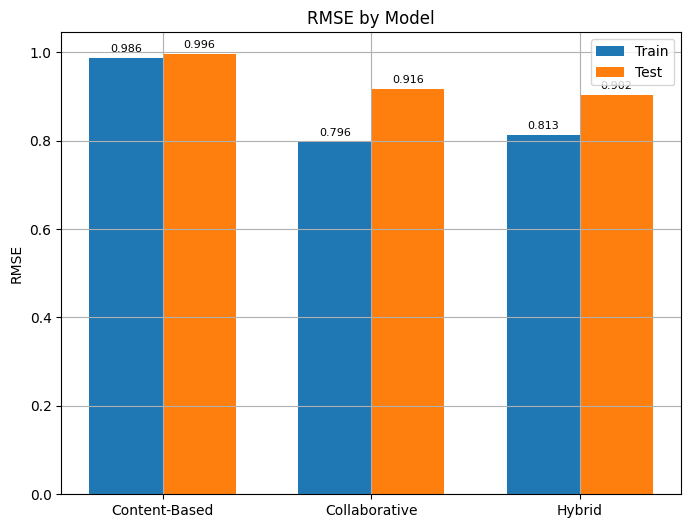

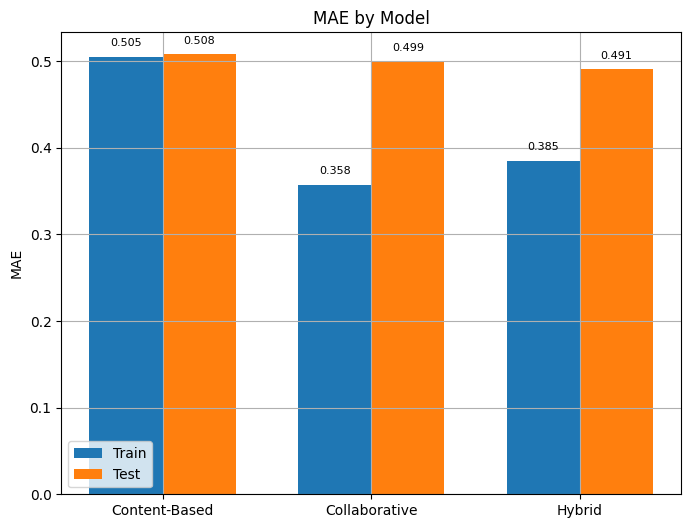

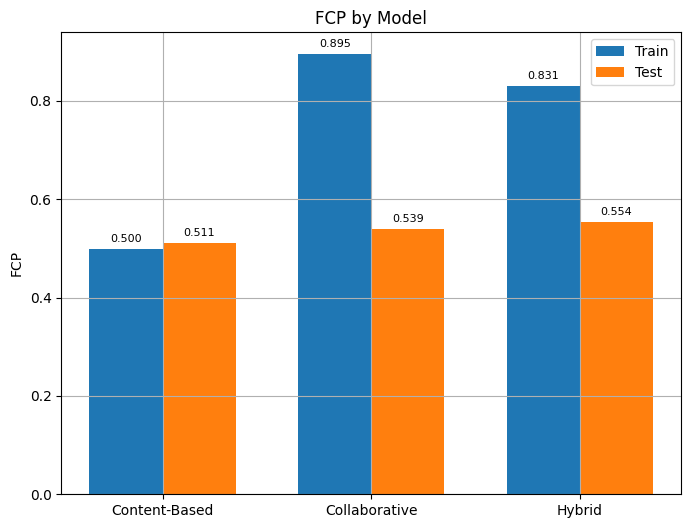

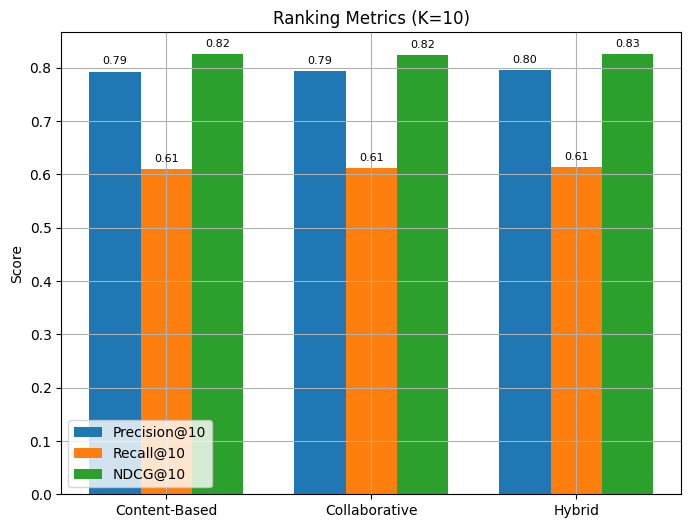

In [15]:
import numpy as np
import matplotlib.pyplot as plt

models = ["Content-Based", "Collaborative", "Hybrid"]
x = np.arange(len(models))
width = 0.35


# RMSE:

plt.figure(figsize=(8,6))
rmse_train_vals = [cbf_rmse_train, cf_rmse_train, hy_rmse_train]
rmse_test_vals  = [cbf_rmse_test,  cf_rmse_test,  hy_rmse_test]

train_pos = x - width/2
test_pos  = x + width/2

plt.bar(train_pos, rmse_train_vals, width, label="Train")
plt.bar(test_pos,  rmse_test_vals,  width, label="Test")

for i in range(len(models)):
    plt.text(train_pos[i], rmse_train_vals[i] + 0.01,
             f"{rmse_train_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)
    plt.text(test_pos[i], rmse_test_vals[i] + 0.01,
             f"{rmse_test_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, models)
plt.ylabel("RMSE")
plt.title("RMSE by Model")
plt.legend()
plt.show()


# MAE:

plt.figure(figsize=(8,6))
mae_train_vals = [cbf_mae_train, cf_mae_train, hy_mae_train]
mae_test_vals  = [cbf_mae_test,  cf_mae_test,  hy_mae_test]

train_pos = x - width/2
test_pos  = x + width/2

plt.bar(train_pos, mae_train_vals, width, label="Train")
plt.bar(test_pos,  mae_test_vals,  width, label="Test")

for i in range(len(models)):
    plt.text(train_pos[i], mae_train_vals[i] + 0.01,
             f"{mae_train_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)
    plt.text(test_pos[i], mae_test_vals[i] + 0.01,
             f"{mae_test_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, models)
plt.ylabel("MAE")
plt.title("MAE by Model")
plt.legend()
plt.show()


# FCP:

plt.figure(figsize=(8,6))
fcp_train_vals = [cbf_fcp_train, cf_fcp_train, hy_fcp_train]
fcp_test_vals  = [cbf_fcp_test,  cf_fcp_test,  hy_fcp_test]

train_pos = x - width/2
test_pos  = x + width/2

plt.bar(train_pos, fcp_train_vals, width, label="Train")
plt.bar(test_pos,  fcp_test_vals,  width, label="Test")

for i in range(len(models)):
    plt.text(train_pos[i], fcp_train_vals[i] + 0.01,
             f"{fcp_train_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)
    plt.text(test_pos[i], fcp_test_vals[i] + 0.01,
             f"{fcp_test_vals[i]:.3f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, models)
plt.ylabel("FCP")
plt.title("FCP by Model")
plt.legend()
plt.show()


# Ranking metrics

plt.figure(figsize=(8,6))
bar_w = 0.25

prec_vals = [cbf_prec10, cf_prec10, hy_prec10]
rec_vals  = [cbf_rec10,  cf_rec10,  hy_rec10]
ndcg_vals = [cbf_ndcg10, cf_ndcg10, hy_ndcg10]

plt.bar(x - bar_w, prec_vals, bar_w, label="Precision@10")
plt.bar(x,         rec_vals,  bar_w, label="Recall@10")
plt.bar(x + bar_w, ndcg_vals, bar_w, label="NDCG@10")

for i in range(len(models)):
    plt.text(x[i] - bar_w, prec_vals[i] + 0.01,
             f"{prec_vals[i]:.2f}", ha="center", va="bottom", fontsize=8)
    plt.text(x[i],         rec_vals[i]  + 0.01,
             f"{rec_vals[i]:.2f}",  ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + bar_w, ndcg_vals[i] + 0.01,
             f"{ndcg_vals[i]:.2f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Ranking Metrics (K=10)")
plt.legend()
plt.show()


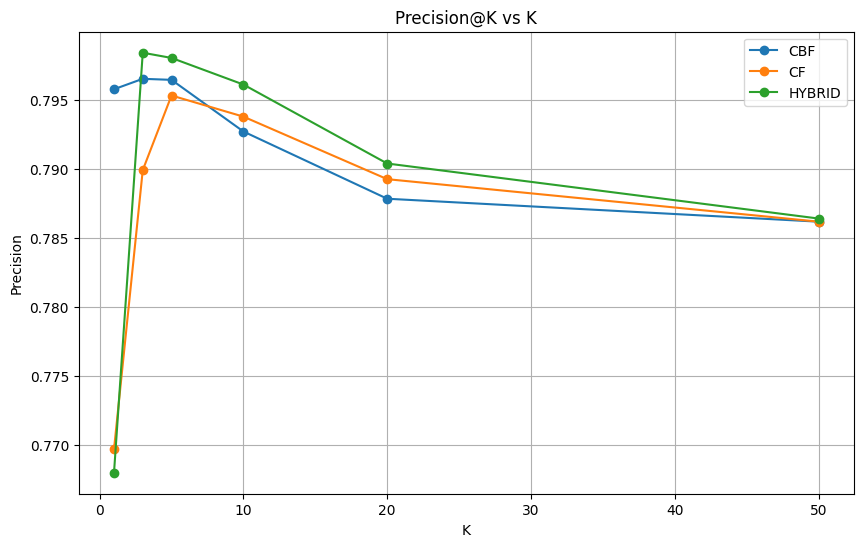

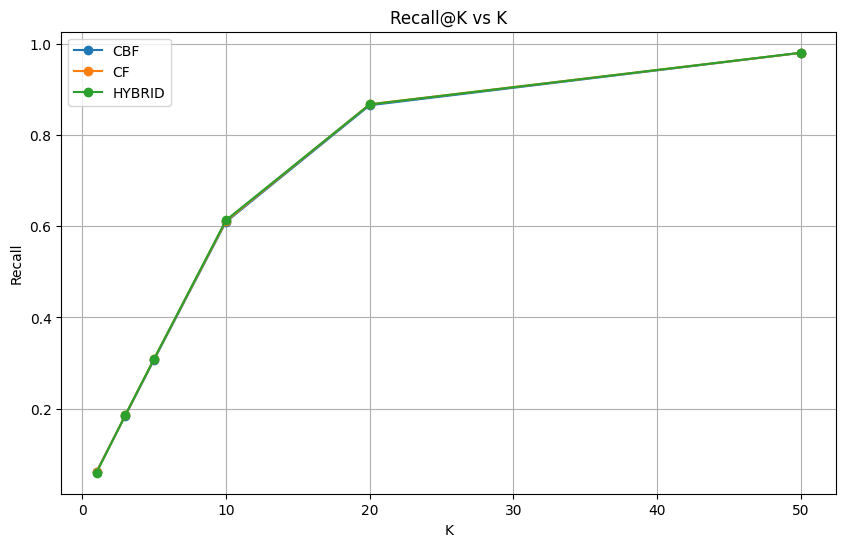

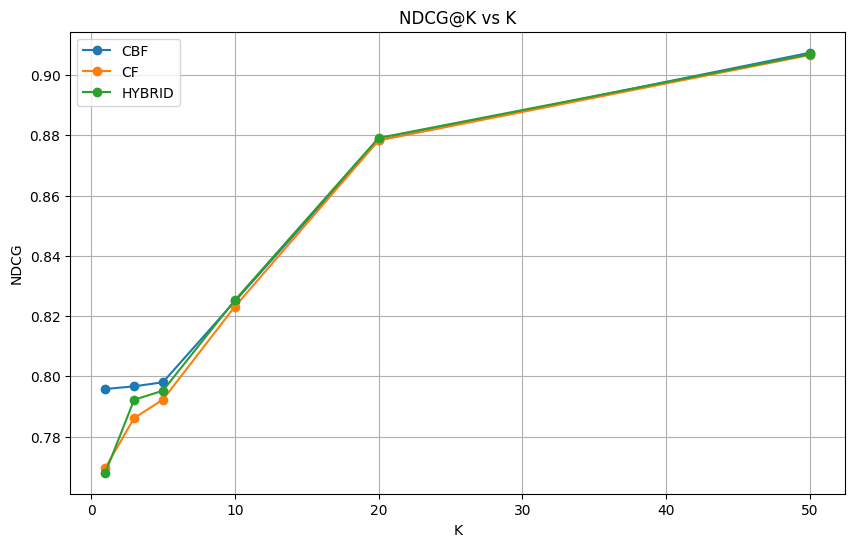

In [16]:

# MULTI-K RANKING METRICS (Precision, Recall, NDCG)


Ks = [1, 3, 5, 10, 20, 50]

def compute_multi_k_metrics(df_test, preds, Ks, rel_th=5):
    prec_values = []
    rec_values  = []
    ndcg_values = []

    for k in Ks:
        p, r, n = ranking_metrics_at_k(df_test, preds, k=k, rel_th=rel_th)
        prec_values.append(p)
        rec_values.append(r)
        ndcg_values.append(n)

    return prec_values, rec_values, ndcg_values


# Compute for all 3 models
cbf_prec_k, cbf_rec_k, cbf_ndcg_k = compute_multi_k_metrics(test_df, cbf_test, Ks)
cf_prec_k,  cf_rec_k,  cf_ndcg_k  = compute_multi_k_metrics(test_df, cf_test, Ks)
hy_prec_k,  hy_rec_k,  hy_ndcg_k  = compute_multi_k_metrics(test_df, hy_test, Ks)



# PLOT — Precision vs K

plt.figure(figsize=(10,6))
plt.plot(Ks, cbf_prec_k, "-o", label="CBF")
plt.plot(Ks, cf_prec_k,  "-o", label="CF")
plt.plot(Ks, hy_prec_k,  "-o", label="HYBRID")

plt.title("Precision@K vs K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()



# PLOT — Recall vs K

plt.figure(figsize=(10,6))
plt.plot(Ks, cbf_rec_k, "-o", label="CBF")
plt.plot(Ks, cf_rec_k,  "-o", label="CF")
plt.plot(Ks, hy_rec_k,  "-o", label="HYBRID")

plt.title("Recall@K vs K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()



# PLOT — NDCG vs K

plt.figure(figsize=(10,6))
plt.plot(Ks, cbf_ndcg_k, "-o", label="CBF")
plt.plot(Ks, cf_ndcg_k,  "-o", label="CF")
plt.plot(Ks, hy_ndcg_k,  "-o", label="HYBRID")

plt.title("NDCG@K vs K")
plt.xlabel("K")
plt.ylabel("NDCG")
plt.grid(True)
plt.legend()
plt.show()


phase 2

In [17]:
# PHASE 2


from sklearn.decomposition import TruncatedSVD

print("TF-IDF matrix shape:", tfidf_matrix.shape)

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
item_content_emb = svd.fit_transform(tfidf_matrix)

print("Content embedding shape:", item_content_emb.shape)

user_mean_p2 = train_df.groupby("AuthorId")["Rating"].mean().to_dict()
item_mean_p2 = train_df.groupby("RecipeId")["Rating"].mean().to_dict()
user_count_p2 = train_df.groupby("AuthorId")["Rating"].size().to_dict()
item_count_p2 = train_df.groupby("RecipeId")["Rating"].size().to_dict()

print("Num users in Phase 2:", len(user_mean_p2))
print("Num items in Phase 2:", len(item_mean_p2))


TF-IDF matrix shape: (10268, 13915)
Content embedding shape: (10268, 100)
Num users in Phase 2: 4416
Num items in Phase 2: 10250


In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error


feat_dim = n_components + 4

def make_X_y(df):
    """
    Build feature matrix X and target y for a given ratings dataframe.
    Features:
      - item content embedding (SVD on TF-IDF)
      - user mean rating in TRAIN
      - item mean rating in TRAIN
      - log user rating count
      - log item rating count
    """
    n = len(df)
    X = np.zeros((n, feat_dim), dtype=np.float32)
    y = df["Rating"].values.astype(np.float32)

    for idx, row in enumerate(df.itertuples(index=False)):
        u = row.AuthorId
        i = row.RecipeId

        item_idx = item_id_to_idx.get(i, None)
        if item_idx is not None:
            X[idx, :n_components] = item_content_emb[item_idx]
        else:
            X[idx, :n_components] = 0.0


        u_mean = user_mean_p2.get(u, global_mean)
        i_mean = item_mean_p2.get(i, global_mean)
        u_cnt  = user_count_p2.get(u, 1)
        i_cnt  = item_count_p2.get(i, 1)

        X[idx, n_components]     = u_mean
        X[idx, n_components + 1] = i_mean
        X[idx, n_components + 2] = np.log1p(u_cnt)
        X[idx, n_components + 3] = np.log1p(i_cnt)

    return X, y

print("Building Phase-2 training/test matrices...")
X_train_cb, y_train_cb = make_X_y(train_df)
X_test_cb,  y_test_cb  = make_X_y(test_df)

print("X_train_cb shape:", X_train_cb.shape)
print("X_test_cb  shape:", X_test_cb.shape)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def fcp_local(df, preds):
    """
    FCP computed on df (must have AuthorId, Rating) with prediction array preds.
    """
    df = df.copy()
    df["pred"] = preds
    total = 0
    concord = 0
    for uid, group in df.groupby("AuthorId"):
        if len(group) < 2:
            continue
        r = group["Rating"].values
        p = group["pred"].values
        n = len(r)
        for i in range(n):
            for j in range(i+1, n):
                if r[i] == r[j]:
                    continue
                total += 1
                if (r[i] - r[j]) * (p[i] - p[j]) > 0:
                    concord += 1
    return concord / total if total > 0 else 0.0

def ranking_metrics_at_k_local(df_test, preds, k=10, rel_th=5,
                               min_test_items=10, min_rel_items=3):
    """
    Precision@k, Recall@k, NDCG@k using only TEST ratings.
    Relevance = rating >= rel_th.
    """
    df = df_test.copy()
    df["pred"] = preds
    df["relevant"] = (df["Rating"] >= rel_th).astype(int)

    prec_list, rec_list, ndcg_list = [], [], []

    for uid, group in df.groupby("AuthorId"):
        if len(group) < min_test_items:
            continue
        if group["relevant"].sum() < min_rel_items:
            continue

        group_sorted = group.sort_values("pred", ascending=False)
        topk = group_sorted.head(k)
        rel = topk["relevant"].values

        # Precision@k
        prec = rel.mean()
        prec_list.append(prec)

        # Recall@k
        total_rel = group["relevant"].sum()
        rec = rel.sum() / total_rel if total_rel > 0 else 0.0
        rec_list.append(rec)

        # NDCG@k
        dcg = np.sum(rel / np.log2(np.arange(2, len(rel) + 2)))
        ideal_rel = np.sort(group["relevant"].values)[::-1][:k]
        idcg = np.sum(ideal_rel / np.log2(np.arange(2, len(ideal_rel) + 2)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_list.append(ndcg)

    if len(prec_list) == 0:
        return 0.0, 0.0, 0.0

    return np.mean(prec_list), np.mean(rec_list), np.mean(ndcg_list)

print("Phase-2 helpers ready.")


Building Phase-2 training/test matrices...
X_train_cb shape: (221247, 104)
X_test_cb  shape: (55312, 104)
Phase-2 helpers ready.


In [19]:
# PHASE 2
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0, random_state=42)

print("Training Ridge Regression (Linear CBF model)...")
ridge_reg.fit(X_train_cb, y_train_cb)

ridge_train_pred = ridge_reg.predict(X_train_cb)
ridge_test_pred  = ridge_reg.predict(X_test_cb)

ridge_rmse_train = rmse(y_train_cb, ridge_train_pred)
ridge_rmse_test  = rmse(y_test_cb,  ridge_test_pred)

ridge_mae_train  = mae(y_train_cb, ridge_train_pred)
ridge_mae_test   = mae(y_test_cb,  ridge_test_pred)

ridge_fcp_train  = fcp_local(train_df, ridge_train_pred)
ridge_fcp_test   = fcp_local(test_df,  ridge_test_pred)

ridge_prec10, ridge_rec10, ridge_ndcg10 = ranking_metrics_at_k_local(
    test_df, ridge_test_pred, k=10, rel_th=5
)

print("Ridge RMSE (train/test):", ridge_rmse_train, ridge_rmse_test)
print("Ridge MAE  (train/test):", ridge_mae_train, ridge_mae_test)
print("Ridge FCP  (train/test):", ridge_fcp_train, ridge_fcp_test)
print("Ridge P@10, R@10, NDCG@10:", ridge_prec10, ridge_rec10, ridge_ndcg10)


Training Ridge Regression (Linear CBF model)...
Ridge RMSE (train/test): 0.8096268177444951 0.8686982475618779
Ridge MAE  (train/test): 0.47022575 0.5013375
Ridge FCP  (train/test): 0.671885840127806 0.6079498512505697
Ridge P@10, R@10, NDCG@10: 0.8192853091321611 0.6289805391270106 0.8602258749376318


In [20]:
# PHASE 2 — MODEL 2: BAYESIAN RIDGE
from sklearn.linear_model import BayesianRidge

bayes_reg = BayesianRidge()

print("Training Bayesian Ridge Regression...")
bayes_reg.fit(X_train_cb, y_train_cb)

bayes_train_pred = bayes_reg.predict(X_train_cb)
bayes_test_pred  = bayes_reg.predict(X_test_cb)

bayes_rmse_train = rmse(y_train_cb, bayes_train_pred)
bayes_rmse_test  = rmse(y_test_cb,  bayes_test_pred)

bayes_mae_train  = mae(y_train_cb, bayes_train_pred)
bayes_mae_test   = mae(y_test_cb,  bayes_test_pred)

bayes_fcp_train  = fcp_local(train_df, bayes_train_pred)
bayes_fcp_test   = fcp_local(test_df,  bayes_test_pred)

bayes_prec10, bayes_rec10, bayes_ndcg10 = ranking_metrics_at_k_local(
    test_df, bayes_test_pred, k=10, rel_th=5
)

print("BayesianRidge RMSE (train/test):", bayes_rmse_train, bayes_rmse_test)
print("BayesianRidge MAE  (train/test):", bayes_mae_train, bayes_mae_test)
print("BayesianRidge FCP  (train/test):", bayes_fcp_train, bayes_fcp_test)
print("BayesianRidge P@10, R@10, NDCG@10:", bayes_prec10, bayes_rec10, bayes_ndcg10)


Training Bayesian Ridge Regression...
BayesianRidge RMSE (train/test): 0.8096277011828045 0.8685639257606673
BayesianRidge MAE  (train/test): 0.4701486 0.50119406
BayesianRidge FCP  (train/test): 0.6719281208884234 0.6079572609357692
BayesianRidge P@10, R@10, NDCG@10: 0.8195121951219512 0.6291771611695808 0.8604472727772932


In [21]:
#  PHASE 2 — MODEL 3: APPROXIMATE KERNEL RIDGE
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge

MAX_TRAIN_SAMPLES_RFF = 120000
N_RFF_COMPONENTS = 150

if len(X_train_cb) > MAX_TRAIN_SAMPLES_RFF:
    np.random.seed(42)
    idx_sub_rff = np.random.choice(len(X_train_cb), size=MAX_TRAIN_SAMPLES_RFF, replace=False)
    X_train_rff_in = X_train_cb[idx_sub_rff]
    y_train_rff    = y_train_cb[idx_sub_rff]
    train_df_rff   = train_df.iloc[idx_sub_rff].reset_index(drop=True)
    print(f"RBF features: using subsample of {MAX_TRAIN_SAMPLES_RFF} / {len(X_train_cb)} training rows.")
else:
    X_train_rff_in = X_train_cb
    y_train_rff    = y_train_cb
    train_df_rff   = train_df.copy()
    print("RBF features: using full training set.")

rbf_feature = RBFSampler(gamma=1.0, n_components=N_RFF_COMPONENTS, random_state=42)

print("Fitting RBFSampler on training subset...")
X_train_rff = rbf_feature.fit_transform(X_train_rff_in)
X_test_rff  = rbf_feature.transform(X_test_cb)

print("RBF feature shapes:", X_train_rff.shape, X_test_rff.shape)

krr_model = Ridge(alpha=1.0, random_state=42)

print("Training Ridge on RBF features (approximate Kernel Ridge)...")
krr_model.fit(X_train_rff, y_train_rff)

# Predictions
krr_train_pred_sub = krr_model.predict(X_train_rff)
krr_test_pred      = krr_model.predict(X_test_rff)

# Metrics
krr_rmse_train = rmse(y_train_rff, krr_train_pred_sub)
krr_rmse_test  = rmse(y_test_cb,  krr_test_pred)

krr_mae_train  = mae(y_train_rff, krr_train_pred_sub)
krr_mae_test   = mae(y_test_cb,  krr_test_pred)

krr_fcp_train  = fcp_local(train_df_rff, krr_train_pred_sub)
krr_fcp_test   = fcp_local(test_df,     krr_test_pred)

krr_prec10, krr_rec10, krr_ndcg10 = ranking_metrics_at_k_local(
    test_df, krr_test_pred, k=10, rel_th=5
)

print("Approx-Kernel RMSE (train/test):", krr_rmse_train, krr_rmse_test)
print("Approx-Kernel MAE  (train/test):", krr_mae_train, krr_mae_test)
print("Approx-Kernel FCP  (train/test):", krr_fcp_train, krr_fcp_test)
print("Approx-Kernel P@10, R@10, NDCG@10:", krr_prec10, krr_rec10, krr_ndcg10)


RBF features: using subsample of 120000 / 221247 training rows.
Fitting RBFSampler on training subset...
RBF feature shapes: (120000, 150) (55312, 150)
Training Ridge on RBF features (approximate Kernel Ridge)...
Approx-Kernel RMSE (train/test): 0.8471695517929193 0.8809190209741924
Approx-Kernel MAE  (train/test): 0.502418 0.52145565
Approx-Kernel FCP  (train/test): 0.5834126708700206 0.5459604248713493
Approx-Kernel P@10, R@10, NDCG@10: 0.8074305161656268 0.622055203425783 0.8450906025266427


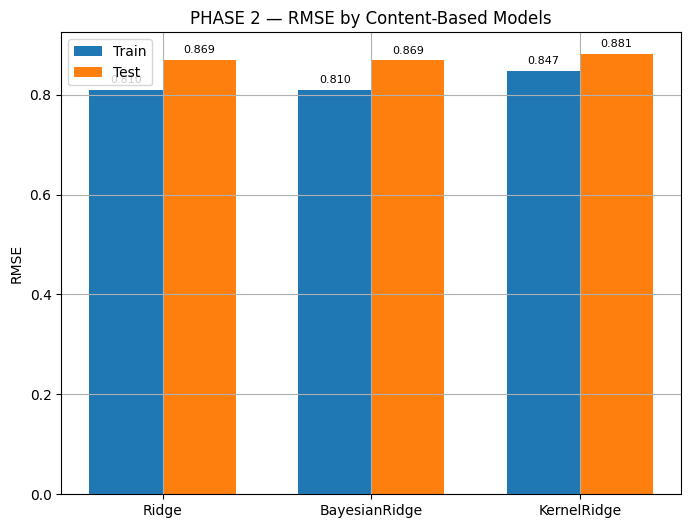

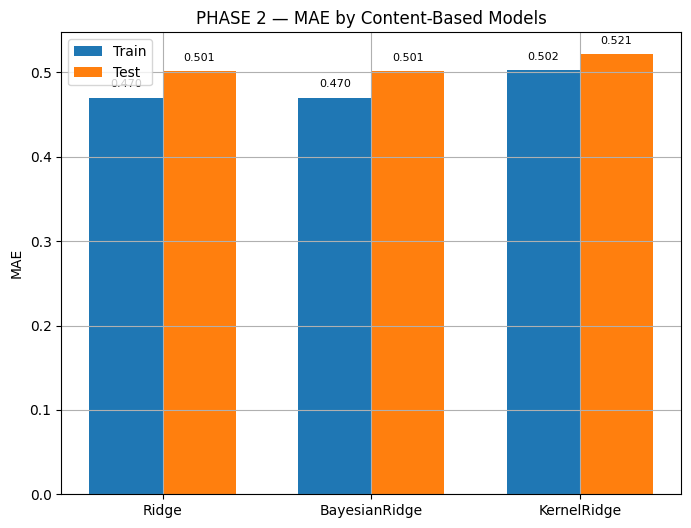

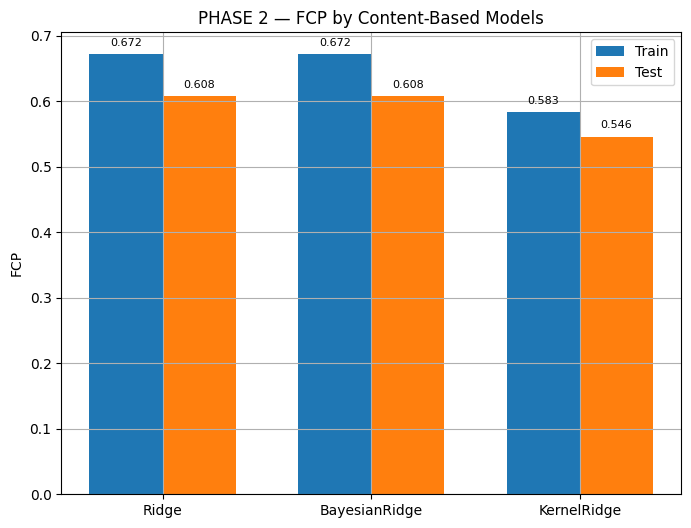

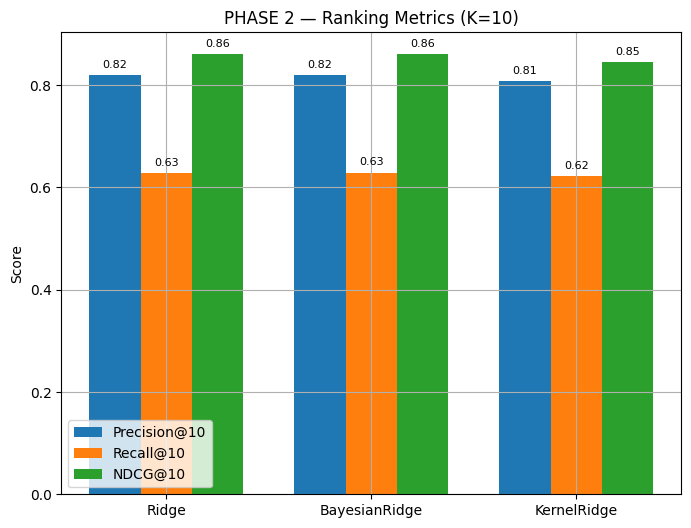

In [22]:
import matplotlib.pyplot as plt
import numpy as np

phase2_models = ["Ridge", "BayesianRidge", "KernelRidge"]
x = np.arange(len(phase2_models))
width = 0.35

# RMSE
rmse_train_vals = [ridge_rmse_train, bayes_rmse_train, krr_rmse_train]
rmse_test_vals  = [ridge_rmse_test,  bayes_rmse_test,  krr_rmse_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_train_vals, width, label="Train")
plt.bar(x + width/2, rmse_test_vals,  width, label="Test")
for i in range(len(phase2_models)):
    plt.text(x[i] - width/2, rmse_train_vals[i] + 0.01, f"{rmse_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, rmse_test_vals[i] + 0.01, f"{rmse_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase2_models)
plt.ylabel("RMSE")
plt.title("PHASE 2 — RMSE by Content-Based Models")
plt.legend()
plt.show()

# MAE
mae_train_vals = [ridge_mae_train, bayes_mae_train, krr_mae_train]
mae_test_vals  = [ridge_mae_test,  bayes_mae_test,  krr_mae_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, mae_train_vals, width, label="Train")
plt.bar(x + width/2, mae_test_vals,  width, label="Test")
for i in range(len(phase2_models)):
    plt.text(x[i] - width/2, mae_train_vals[i] + 0.01, f"{mae_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, mae_test_vals[i] + 0.01, f"{mae_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase2_models)
plt.ylabel("MAE")
plt.title("PHASE 2 — MAE by Content-Based Models")
plt.legend()
plt.show()

# FCP
fcp_train_vals = [ridge_fcp_train, bayes_fcp_train, krr_fcp_train]
fcp_test_vals  = [ridge_fcp_test,  bayes_fcp_test,  krr_fcp_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, fcp_train_vals, width, label="Train")
plt.bar(x + width/2, fcp_test_vals,  width, label="Test")
for i in range(len(phase2_models)):
    plt.text(x[i] - width/2, fcp_train_vals[i] + 0.01, f"{fcp_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, fcp_test_vals[i] + 0.01, f"{fcp_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase2_models)
plt.ylabel("FCP")
plt.title("PHASE 2 — FCP by Content-Based Models")
plt.legend()
plt.show()

# Ranking metrics
prec_vals = [ridge_prec10, bayes_prec10, krr_prec10]
rec_vals  = [ridge_rec10,  bayes_rec10,  krr_rec10]
ndcg_vals = [ridge_ndcg10, bayes_ndcg10, krr_ndcg10]

bar_w = 0.25
plt.figure(figsize=(8,6))
plt.bar(x - bar_w, prec_vals, bar_w, label="Precision@10")
plt.bar(x,         rec_vals,  bar_w, label="Recall@10")
plt.bar(x + bar_w, ndcg_vals, bar_w, label="NDCG@10")

for i in range(len(phase2_models)):
    plt.text(x[i] - bar_w, prec_vals[i] + 0.01, f"{prec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i],         rec_vals[i]  + 0.01, f"{rec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + bar_w, ndcg_vals[i] + 0.01, f"{ndcg_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)

plt.xticks(x, phase2_models)
plt.ylabel("Score")
plt.title("PHASE 2 — Ranking Metrics (K=10)")
plt.legend()
plt.show()


In [23]:

#  MULTI-K Ranking Metrics for Phase 2 Models

Ks = [1, 3, 5, 10, 20, 50]

def compute_multi_k_phase2(df_test, preds, Ks, rel_th=5):
    prec_values = []
    rec_values = []
    ndcg_values = []

    for k in Ks:
        p, r, n = ranking_metrics_at_k_local(df_test, preds, k=k, rel_th=rel_th)
        prec_values.append(p)
        rec_values.append(r)
        ndcg_values.append(n)

    return prec_values, rec_values, ndcg_values

# Compute for ALL 3 Phase-2 models
ridge_prec_k, ridge_rec_k, ridge_ndcg_k = compute_multi_k_phase2(test_df, ridge_test_pred, Ks)
bayes_prec_k, bayes_rec_k, bayes_ndcg_k = compute_multi_k_phase2(test_df, bayes_test_pred, Ks)
krr_prec_k,   krr_rec_k,   krr_ndcg_k   = compute_multi_k_phase2(test_df, krr_test_pred, Ks)

print("Multi-K evaluation completed for Phase-2 models.")


Multi-K evaluation completed for Phase-2 models.


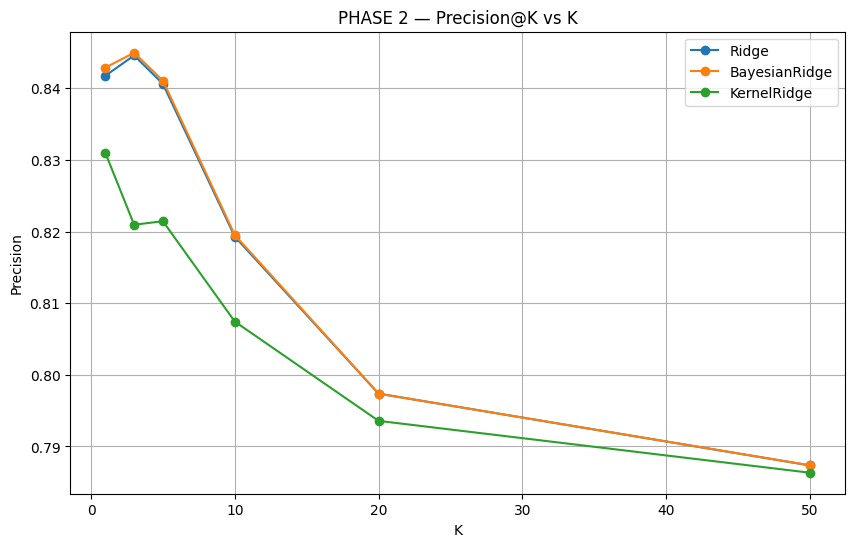

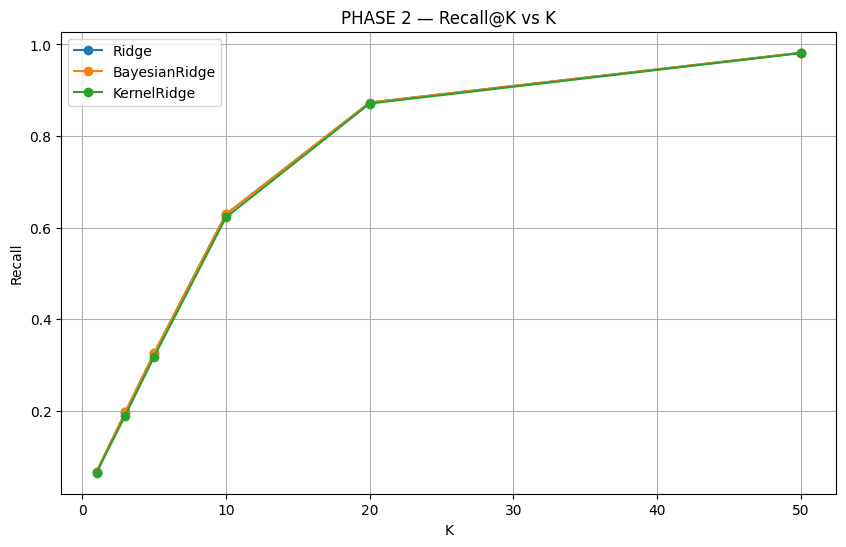

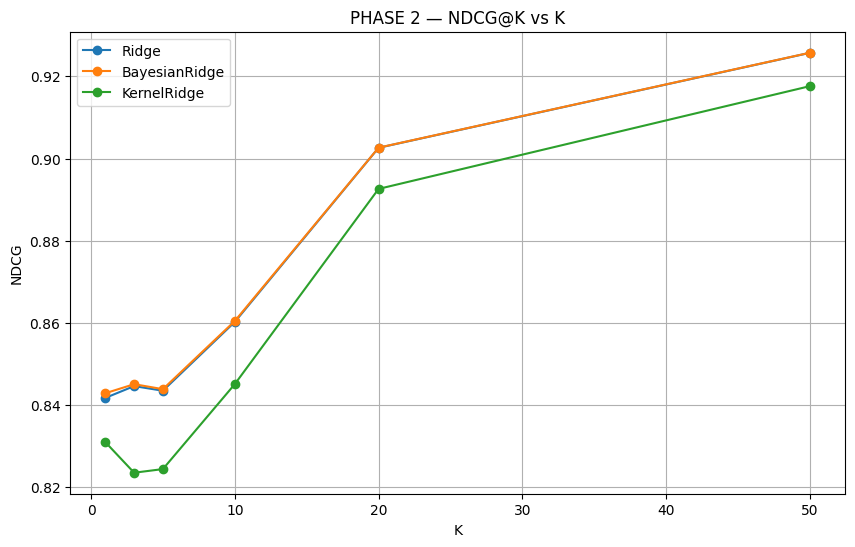

In [24]:

# PLOT Multi-K Curves for Precision, Recall, NDCG


# Precision vs K
plt.figure(figsize=(10,6))
plt.plot(Ks, ridge_prec_k, "-o", label="Ridge")
plt.plot(Ks, bayes_prec_k, "-o", label="BayesianRidge")
plt.plot(Ks, krr_prec_k, "-o", label="KernelRidge")

plt.title("PHASE 2 — Precision@K vs K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()


# Recall vs K
plt.figure(figsize=(10,6))
plt.plot(Ks, ridge_rec_k, "-o", label="Ridge")
plt.plot(Ks, bayes_rec_k, "-o", label="BayesianRidge")
plt.plot(Ks, krr_rec_k, "-o", label="KernelRidge")

plt.title("PHASE 2 — Recall@K vs K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()


# NDCG vs K
plt.figure(figsize=(10,6))
plt.plot(Ks, ridge_ndcg_k, "-o", label="Ridge")
plt.plot(Ks, bayes_ndcg_k, "-o", label="BayesianRidge")
plt.plot(Ks, krr_ndcg_k, "-o", label="KernelRidge")

plt.title("PHASE 2 — NDCG@K vs K")
plt.xlabel("K")
plt.ylabel("NDCG")
plt.grid(True)
plt.legend()
plt.show()


phase 3

In [25]:
import numpy as np

print("Phase 3 prep: building dense rating matrix and training triplets...")

R_dense = np.zeros((n_users, n_items), dtype=np.float32)
for row in train_df.itertuples(index=False):
    u = user_id_to_idx[row.AuthorId]
    i = item_id_to_idx[row.RecipeId]
    R_dense[u, i] = row.Rating

item_means_cf = np.zeros(n_items, dtype=np.float32)
for j in range(n_items):
    mask = R_dense[:, j] > 0
    if mask.any():
        item_means_cf[j] = R_dense[mask, j].mean()
    else:
        item_means_cf[j] = global_mean


R_items_centered = R_dense.copy()
for j in range(n_items):
    mask = R_items_centered[:, j] > 0
    R_items_centered[mask, j] = R_items_centered[mask, j] - item_means_cf[j]

I_centered = R_items_centered.T

print("I_centered shape (items x users):", I_centered.shape)

ratings_arr = []
for row in train_df.itertuples(index=False):
    u = user_id_to_idx[row.AuthorId]
    i = item_id_to_idx[row.RecipeId]
    ratings_arr.append((u, i, float(row.Rating)))

ratings_arr = np.array(ratings_arr, dtype=np.float32)
print("Total train ratings:", ratings_arr.shape[0])

MAX_RATINGS_MF = 300000

if len(ratings_arr) > MAX_RATINGS_MF:
    np.random.seed(42)
    idx_sub = np.random.choice(len(ratings_arr), size=MAX_RATINGS_MF, replace=False)
    ratings_mf = ratings_arr[idx_sub]
    print(f"Using subsample of {MAX_RATINGS_MF} / {len(ratings_arr)} ratings for MF/PMF.")
else:
    ratings_mf = ratings_arr
    print("Using full set of ratings for MF/PMF.")

ratings_mf[:5]


Phase 3 prep: building dense rating matrix and training triplets...
I_centered shape (items x users): (10268, 4416)
Total train ratings: 221247
Using full set of ratings for MF/PMF.


array([[2.942e+03, 7.725e+03, 4.000e+00],
       [1.129e+03, 8.599e+03, 4.000e+00],
       [2.600e+01, 2.590e+02, 1.000e+00],
       [2.446e+03, 8.628e+03, 0.000e+00],
       [3.128e+03, 5.309e+03, 5.000e+00]], dtype=float32)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

print("Phase 3 — Item–Item CF: computing top-K similarities...")

TOP_K_ITEMCF = 100
BATCH_ITEMCF = 500

itemcf_sim_indices = np.zeros((n_items, TOP_K_ITEMCF), dtype=np.int32)
itemcf_sim_scores  = np.zeros((n_items, TOP_K_ITEMCF), dtype=np.float32)

for start in range(0, n_items, BATCH_ITEMCF):
    end = min(start + BATCH_ITEMCF, n_items)
    sims = cosine_similarity(I_centered[start:end], I_centered)  # (batch, n_items)
    for i in range(end - start):
        sims[i, start + i] = 0.0  # remove self-similarity

    topk_idx = np.argpartition(-sims, TOP_K_ITEMCF, axis=1)[:, :TOP_K_ITEMCF]

    for i in range(end - start):
        idxs = topk_idx[i]
        scores = sims[i, idxs]
        order = np.argsort(-scores)
        itemcf_sim_indices[start + i] = idxs[order]
        itemcf_sim_scores[start + i]  = scores[order]

print("Item–Item CF similarity structure ready.")


def predict_itemcf_single(user_id, recipe_id, k=50):
    if user_id not in user_id_to_idx or recipe_id not in item_id_to_idx:
        return global_mean

    u_idx = user_id_to_idx[user_id]
    i_idx = item_id_to_idx[recipe_id]

    neighbors = itemcf_sim_indices[i_idx]
    sims      = itemcf_sim_scores[i_idx]


    used_ratings = []
    used_sims    = []

    for nb_idx, s in zip(neighbors, sims):
        r_ui_nb = R_dense[u_idx, nb_idx]
        if r_ui_nb > 0:
            used_ratings.append(r_ui_nb)
            used_sims.append(s)

    if len(used_ratings) == 0:
        return item_means_cf[i_idx] if item_means_cf[i_idx] > 0 else global_mean

    used_ratings = np.array(used_ratings)
    used_sims    = np.array(used_sims)

    num = np.sum(used_sims * (used_ratings - item_means_cf[neighbors[:len(used_ratings)]]))
    denom = np.sum(np.abs(used_sims))
    if denom == 0:
        return item_means_cf[i_idx]

    return item_means_cf[i_idx] + num / denom

def predict_itemcf_df(df):
    preds = []
    for row in df.itertuples(index=False):
        preds.append(predict_itemcf_single(row.AuthorId, row.RecipeId))
    return np.array(preds, dtype=np.float32)

print("Predicting Item–Item CF for train/test...")

itemcf_train_pred = predict_itemcf_df(train_df)
itemcf_test_pred  = predict_itemcf_df(test_df)

itemcf_rmse_train = rmse(train_df["Rating"].values, itemcf_train_pred)
itemcf_rmse_test  = rmse(test_df["Rating"].values,  itemcf_test_pred)

itemcf_mae_train  = mae(train_df["Rating"].values, itemcf_train_pred)
itemcf_mae_test   = mae(test_df["Rating"].values,  itemcf_test_pred)

itemcf_fcp_train  = fcp_local(train_df, itemcf_train_pred)
itemcf_fcp_test   = fcp_local(test_df,  itemcf_test_pred)

itemcf_prec10, itemcf_rec10, itemcf_ndcg10 = ranking_metrics_at_k_local(
    test_df, itemcf_test_pred, k=10, rel_th=5
)

print("Item–Item CF RMSE (train/test):", itemcf_rmse_train, itemcf_rmse_test)
print("Item–Item CF MAE  (train/test):", itemcf_mae_train, itemcf_mae_test)
print("Item–Item CF FCP  (train/test):", itemcf_fcp_train, itemcf_fcp_test)
print("Item–Item CF P@10, R@10, NDCG@10:", itemcf_prec10, itemcf_rec10, itemcf_ndcg10)


Phase 3 — Item–Item CF: computing top-K similarities...
Item–Item CF similarity structure ready.
Predicting Item–Item CF for train/test...
Item–Item CF RMSE (train/test): 0.80649648491554 0.9352172079590787
Item–Item CF MAE  (train/test): 0.3892993413180049 0.5073532599148669
Item–Item CF FCP  (train/test): 0.8955110561915854 0.5825457455440005
Item–Item CF P@10, R@10, NDCG@10: 0.8124220079410097 0.6240694705292875 0.849950785159659


In [27]:
print("Phase 3 — Matrix Factorization (MF) training...")

n_factors_mf = 20
n_epochs_mf  = 10
lr_mf        = 0.01
reg_mf       = 0.05

user_factors_mf = 0.01 * np.random.randn(n_users, n_factors_mf)
item_factors_mf = 0.01 * np.random.randn(n_items, n_factors_mf)
user_bias_mf    = np.zeros(n_users, dtype=np.float32)
item_bias_mf    = np.zeros(n_items, dtype=np.float32)

for epoch in range(n_epochs_mf):
    np.random.shuffle(ratings_mf)
    sq_err_sum = 0.0

    for (u_idx, i_idx, r) in ratings_mf:
        u_idx = int(u_idx)
        i_idx = int(i_idx)
        r = float(r)


        pred = (
            global_mean
            + user_bias_mf[u_idx]
            + item_bias_mf[i_idx]
            + np.dot(user_factors_mf[u_idx], item_factors_mf[i_idx])
        )

        err = r - pred
        sq_err_sum += err * err


        ub = user_bias_mf[u_idx]
        ib = item_bias_mf[i_idx]
        uf = user_factors_mf[u_idx]
        itf = item_factors_mf[i_idx]

        user_bias_mf[u_idx] += lr_mf * (err - reg_mf * ub)
        item_bias_mf[i_idx] += lr_mf * (err - reg_mf * ib)

        user_factors_mf[u_idx] += lr_mf * (err * itf - reg_mf * uf)
        item_factors_mf[i_idx] += lr_mf * (err * uf  - reg_mf * itf)

    rmse_epoch = np.sqrt(sq_err_sum / len(ratings_mf))
    print(f"MF Epoch {epoch+1}/{n_epochs_mf} — train RMSE (on used ratings): {rmse_epoch:.4f}")

def predict_mf_single(user_id, recipe_id):
    if user_id not in user_id_to_idx or recipe_id not in item_id_to_idx:
        return global_mean
    u = user_id_to_idx[user_id]
    i = item_id_to_idx[recipe_id]
    return (
        global_mean
        + user_bias_mf[u]
        + item_bias_mf[i]
        + np.dot(user_factors_mf[u], item_factors_mf[i])
    )

def predict_mf_df(df):
    preds = []
    for row in df.itertuples(index=False):
        preds.append(predict_mf_single(row.AuthorId, row.RecipeId))
    return np.array(preds, dtype=np.float32)

print("Predicting MF for train/test...")

mf_train_pred = predict_mf_df(train_df)
mf_test_pred  = predict_mf_df(test_df)

mf_rmse_train = rmse(train_df["Rating"].values, mf_train_pred)
mf_rmse_test  = rmse(test_df["Rating"].values,  mf_test_pred)

mf_mae_train  = mae(train_df["Rating"].values, mf_train_pred)
mf_mae_test   = mae(test_df["Rating"].values,  mf_test_pred)

mf_fcp_train  = fcp_local(train_df, mf_train_pred)
mf_fcp_test   = fcp_local(test_df,  mf_test_pred)

mf_prec10, mf_rec10, mf_ndcg10 = ranking_metrics_at_k_local(
    test_df, mf_test_pred, k=10, rel_th=5
)

print("MF RMSE (train/test):", mf_rmse_train, mf_rmse_test)
print("MF MAE  (train/test):", mf_mae_train, mf_mae_test)
print("MF FCP  (train/test):", mf_fcp_train, mf_fcp_test)
print("MF P@10, R@10, NDCG@10:", mf_prec10, mf_rec10, mf_ndcg10)


Phase 3 — Matrix Factorization (MF) training...
MF Epoch 1/10 — train RMSE (on used ratings): 0.8718
MF Epoch 2/10 — train RMSE (on used ratings): 0.8474
MF Epoch 3/10 — train RMSE (on used ratings): 0.8368
MF Epoch 4/10 — train RMSE (on used ratings): 0.8307
MF Epoch 5/10 — train RMSE (on used ratings): 0.8266
MF Epoch 6/10 — train RMSE (on used ratings): 0.8239
MF Epoch 7/10 — train RMSE (on used ratings): 0.8218
MF Epoch 8/10 — train RMSE (on used ratings): 0.8204
MF Epoch 9/10 — train RMSE (on used ratings): 0.8192
MF Epoch 10/10 — train RMSE (on used ratings): 0.8183
Predicting MF for train/test...
MF RMSE (train/test): 0.8107617932078587 0.8600867358537325
MF MAE  (train/test): 0.46662694015096107 0.49309958787815467
MF FCP  (train/test): 0.6750989506187994 0.6114546323499446
MF P@10, R@10, NDCG@10: 0.8207600680657969 0.6300219618655348 0.8636682582236221


In [28]:
print("Phase 3 — PMF-style training...")

n_factors_pmf = 20
n_epochs_pmf  = 8
lr_pmf        = 0.008
reg_pmf       = 0.08

user_factors_pmf = 0.01 * np.random.randn(n_users, n_factors_pmf)
item_factors_pmf = 0.01 * np.random.randn(n_items, n_factors_pmf)

for epoch in range(n_epochs_pmf):
    np.random.shuffle(ratings_mf)
    sq_err_sum = 0.0

    for (u_idx, i_idx, r) in ratings_mf:
        u_idx = int(u_idx)
        i_idx = int(i_idx)
        r = float(r)

        pred = global_mean + np.dot(user_factors_pmf[u_idx], item_factors_pmf[i_idx])
        err = r - pred
        sq_err_sum += err * err

        uf = user_factors_pmf[u_idx]
        itf = item_factors_pmf[i_idx]

        user_factors_pmf[u_idx] += lr_pmf * (err * itf - reg_pmf * uf)
        item_factors_pmf[i_idx] += lr_pmf * (err * uf  - reg_pmf * itf)

    rmse_epoch = np.sqrt(sq_err_sum / len(ratings_mf))
    print(f"PMF Epoch {epoch+1}/{n_epochs_pmf} — train RMSE (on used ratings): {rmse_epoch:.4f}")

def predict_pmf_single(user_id, recipe_id):
    if user_id not in user_id_to_idx or recipe_id not in item_id_to_idx:
        return global_mean
    u = user_id_to_idx[user_id]
    i = item_id_to_idx[recipe_id]
    return global_mean + np.dot(user_factors_pmf[u], item_factors_pmf[i])

def predict_pmf_df(df):
    preds = []
    for row in df.itertuples(index=False):
        preds.append(predict_pmf_single(row.AuthorId, row.RecipeId))
    return np.array(preds, dtype=np.float32)

print("Predicting PMF for train/test...")

pmf_train_pred = predict_pmf_df(train_df)
pmf_test_pred  = predict_pmf_df(test_df)

pmf_rmse_train = rmse(train_df["Rating"].values, pmf_train_pred)
pmf_rmse_test  = rmse(test_df["Rating"].values,  pmf_test_pred)

pmf_mae_train  = mae(train_df["Rating"].values, pmf_train_pred)
pmf_mae_test   = mae(test_df["Rating"].values,  pmf_test_pred)

pmf_fcp_train  = fcp_local(train_df, pmf_train_pred)
pmf_fcp_test   = fcp_local(test_df,  pmf_test_pred)

pmf_prec10, pmf_rec10, pmf_ndcg10 = ranking_metrics_at_k_local(
    test_df, pmf_test_pred, k=10, rel_th=5
)

print("PMF RMSE (train/test):", pmf_rmse_train, pmf_rmse_test)
print("PMF MAE  (train/test):", pmf_mae_train, pmf_mae_test)
print("PMF FCP  (train/test):", pmf_fcp_train, pmf_fcp_test)
print("PMF P@10, R@10, NDCG@10:", pmf_prec10, pmf_rec10, pmf_ndcg10)


Phase 3 — PMF-style training...
PMF Epoch 1/8 — train RMSE (on used ratings): 0.8933
PMF Epoch 2/8 — train RMSE (on used ratings): 0.8933
PMF Epoch 3/8 — train RMSE (on used ratings): 0.8933
PMF Epoch 4/8 — train RMSE (on used ratings): 0.8932
PMF Epoch 5/8 — train RMSE (on used ratings): 0.8932
PMF Epoch 6/8 — train RMSE (on used ratings): 0.8932
PMF Epoch 7/8 — train RMSE (on used ratings): 0.8932
PMF Epoch 8/8 — train RMSE (on used ratings): 0.8932
Predicting PMF for train/test...
PMF RMSE (train/test): 0.8931328783695529 0.8971247494768843
PMF MAE  (train/test): 0.5644493387926592 0.5651851942386109
PMF FCP  (train/test): 0.6589322425806358 0.5026841584635277
PMF P@10, R@10, NDCG@10: 0.7868406125921726 0.6062131765406582 0.8162734731884913


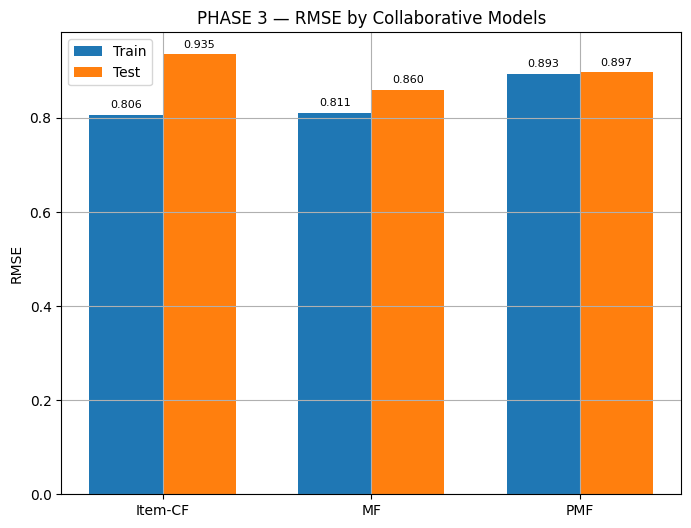

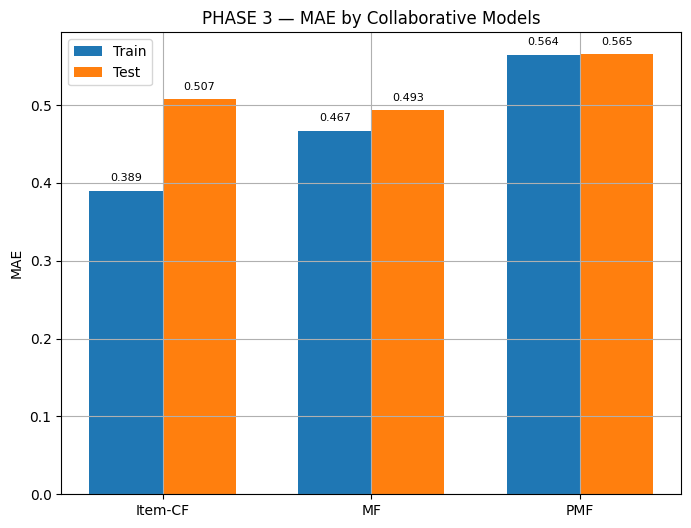

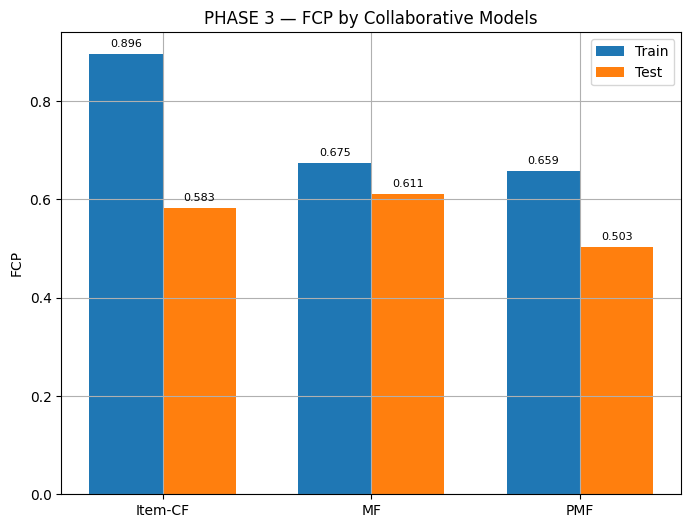

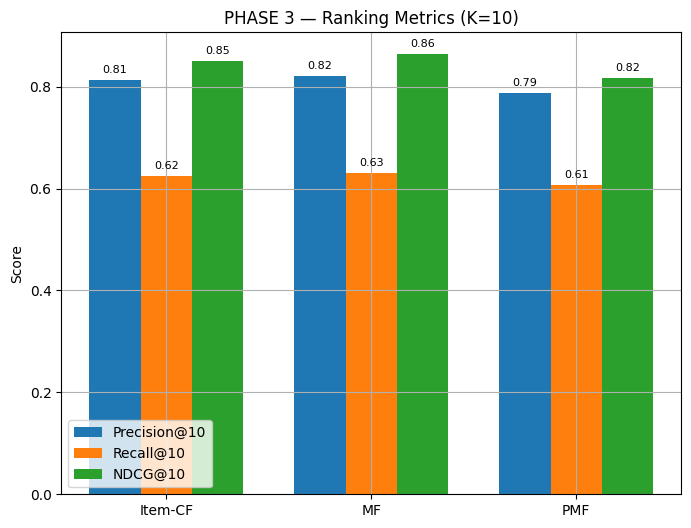

In [29]:
import matplotlib.pyplot as plt
import numpy as np

phase3_models = ["Item-CF", "MF", "PMF"]
x = np.arange(len(phase3_models))
width = 0.35

# RMSE
rmse_train_vals = [itemcf_rmse_train, mf_rmse_train, pmf_rmse_train]
rmse_test_vals  = [itemcf_rmse_test,  mf_rmse_test,  pmf_rmse_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_train_vals, width, label="Train")
plt.bar(x + width/2, rmse_test_vals,  width, label="Test")
for i in range(len(phase3_models)):
    plt.text(x[i] - width/2, rmse_train_vals[i] + 0.01, f"{rmse_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, rmse_test_vals[i] + 0.01, f"{rmse_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase3_models)
plt.ylabel("RMSE")
plt.title("PHASE 3 — RMSE by Collaborative Models")
plt.legend()
plt.show()

# MAE
mae_train_vals = [itemcf_mae_train, mf_mae_train, pmf_mae_train]
mae_test_vals  = [itemcf_mae_test,  mf_mae_test,  pmf_mae_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, mae_train_vals, width, label="Train")
plt.bar(x + width/2, mae_test_vals,  width, label="Test")
for i in range(len(phase3_models)):
    plt.text(x[i] - width/2, mae_train_vals[i] + 0.01, f"{mae_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, mae_test_vals[i] + 0.01, f"{mae_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase3_models)
plt.ylabel("MAE")
plt.title("PHASE 3 — MAE by Collaborative Models")
plt.legend()
plt.show()

# FCP
fcp_train_vals = [itemcf_fcp_train, mf_fcp_train, pmf_fcp_train]
fcp_test_vals  = [itemcf_fcp_test,  mf_fcp_test,  pmf_fcp_test]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, fcp_train_vals, width, label="Train")
plt.bar(x + width/2, fcp_test_vals,  width, label="Test")
for i in range(len(phase3_models)):
    plt.text(x[i] - width/2, fcp_train_vals[i] + 0.01, f"{fcp_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, fcp_test_vals[i] + 0.01, f"{fcp_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, phase3_models)
plt.ylabel("FCP")
plt.title("PHASE 3 — FCP by Collaborative Models")
plt.legend()
plt.show()

# Ranking metrics
prec_vals = [itemcf_prec10, mf_prec10, pmf_prec10]
rec_vals  = [itemcf_rec10,  mf_rec10,  pmf_rec10]
ndcg_vals = [itemcf_ndcg10, mf_ndcg10, pmf_ndcg10]

bar_w = 0.25
plt.figure(figsize=(8,6))
plt.bar(x - bar_w, prec_vals, bar_w, label="Precision@10")
plt.bar(x,         rec_vals,  bar_w, label="Recall@10")
plt.bar(x + bar_w, ndcg_vals, bar_w, label="NDCG@10")

for i in range(len(phase3_models)):
    plt.text(x[i] - bar_w, prec_vals[i] + 0.01, f"{prec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i],         rec_vals[i]  + 0.01, f"{rec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + bar_w, ndcg_vals[i] + 0.01, f"{ndcg_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)

plt.xticks(x, phase3_models)
plt.ylabel("Score")
plt.title("PHASE 3 — Ranking Metrics (K=10)")
plt.legend()
plt.show()


In [30]:

# PHASE 3 - K-VALUES EVAL

K_values = [1, 3, 5, 10, 20, 50]

phase3_prec = {"ItemCF": [], "MF": [], "PMF": []}
phase3_rec  = {"ItemCF": [], "MF": [], "PMF": []}
phase3_ndcg = {"ItemCF": [], "MF": [], "PMF": []}

for K in K_values:
    p_icf, r_icf, n_icf = ranking_metrics_at_k_local(test_df, itemcf_test_pred, K, rel_th=5)
    p_mf,  r_mf,  n_mf  = ranking_metrics_at_k_local(test_df, mf_test_pred,     K, rel_th=5)
    p_pmf, r_pmf, n_pmf = ranking_metrics_at_k_local(test_df, pmf_test_pred,    K, rel_th=5)

    phase3_prec["ItemCF"].append(p_icf)
    phase3_prec["MF"].append(p_mf)
    phase3_prec["PMF"].append(p_pmf)

    phase3_rec["ItemCF"].append(r_icf)
    phase3_rec["MF"].append(r_mf)
    phase3_rec["PMF"].append(r_pmf)

    phase3_ndcg["ItemCF"].append(n_icf)
    phase3_ndcg["MF"].append(n_mf)
    phase3_ndcg["PMF"].append(n_pmf)

print("Phase 3 multiple-K evaluation completed.")


Phase 3 multiple-K evaluation completed.


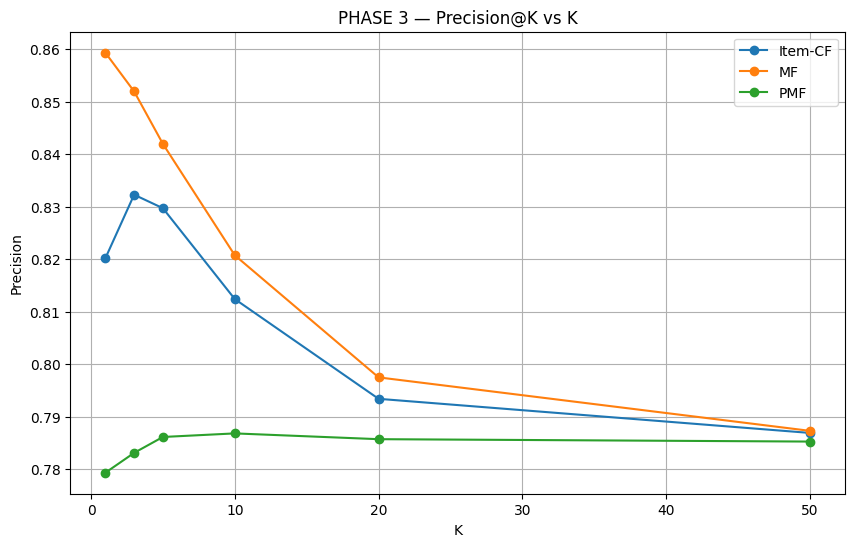

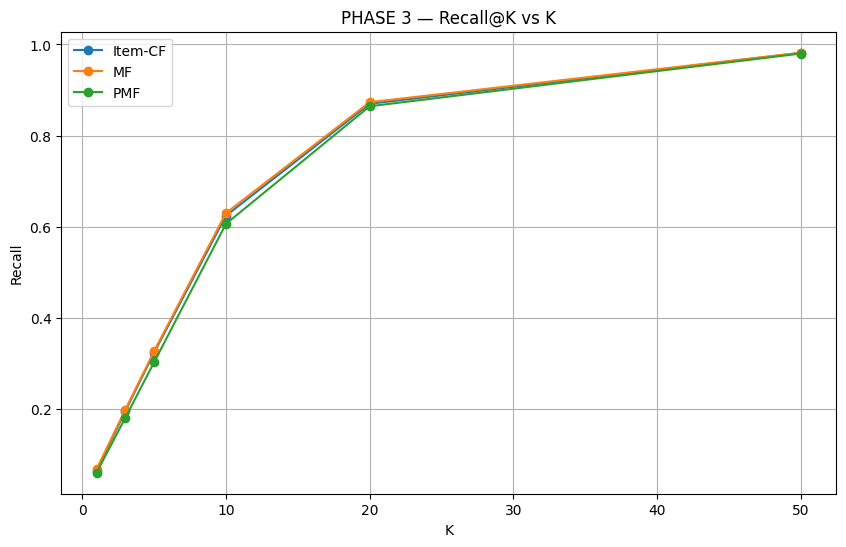

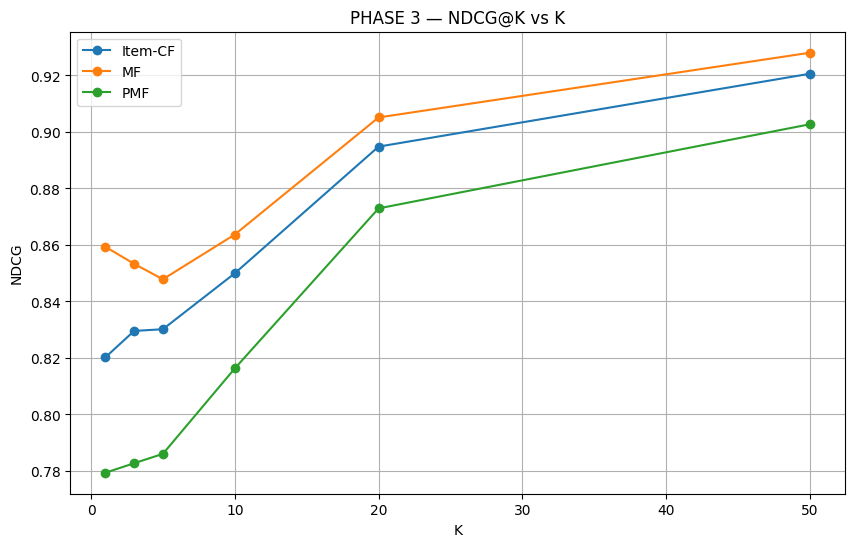

In [31]:

# PHASE 3 — Precision@K vs K graph

plt.figure(figsize=(10,6))
plt.plot(K_values, phase3_prec["ItemCF"], marker="o", label="Item-CF")
plt.plot(K_values, phase3_prec["MF"],     marker="o", label="MF")
plt.plot(K_values, phase3_prec["PMF"],    marker="o", label="PMF")

plt.title("PHASE 3 — Precision@K vs K")
plt.xlabel("K")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

# PHASE 3 — Recall@K vs K graph

plt.figure(figsize=(10,6))
plt.plot(K_values, phase3_rec["ItemCF"], marker="o", label="Item-CF")
plt.plot(K_values, phase3_rec["MF"],     marker="o", label="MF")
plt.plot(K_values, phase3_rec["PMF"],    marker="o", label="PMF")

plt.title("PHASE 3 — Recall@K vs K")
plt.xlabel("K")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()

# PHASE 3 — NDCG@K vs K graph

plt.figure(figsize=(10,6))
plt.plot(K_values, phase3_ndcg["ItemCF"], marker="o", label="Item-CF")
plt.plot(K_values, phase3_ndcg["MF"],     marker="o", label="MF")
plt.plot(K_values, phase3_ndcg["PMF"],    marker="o", label="PMF")

plt.title("PHASE 3 — NDCG@K vs K")
plt.xlabel("K")
plt.ylabel("NDCG")
plt.grid(True)
plt.legend()
plt.show()



phase 4

In [32]:
import numpy as np
import pandas as pd

print("PHASE 4 — Hybrid models: preparation")

y_train = train_df["Rating"].values.astype(np.float32)
y_test  = test_df["Rating"].values.astype(np.float32)

def pick_best_cbf():
    candidates = []
    if "kernel_train_pred" in globals():
        candidates.append(("KernelCBF", kernel_train_pred, kernel_test_pred))
    if "ridge_train_pred" in globals():
        candidates.append(("RidgeCBF", ridge_train_pred, ridge_test_pred))
    if "cbf_train_pred" in globals():
        candidates.append(("Phase1CBF", cbf_train_pred, cbf_test_pred))

    if not candidates:
        raise RuntimeError("No CBF predictions found. Make sure Phase 1/2 models ran.")

    best_name = None
    best_rmse = np.inf
    best_train = None
    best_test = None

    for name, tr, te in candidates:
        r = rmse(y_test, te)
        print(f"  CBF candidate {name}: Test RMSE = {r:.4f}")
        if r < best_rmse:
            best_rmse = r
            best_name = name
            best_train = tr
            best_test = te

    print(f"=> Selected main CBF model: {best_name} (Test RMSE={best_rmse:.4f})")
    return best_name, best_train.astype(np.float32), best_test.astype(np.float32)

cbf_name, cbf_main_train, cbf_main_test = pick_best_cbf()

assert "mf_train_pred" in globals() and "mf_test_pred" in globals(), "MF predictions missing"
assert "pmf_train_pred" in globals() and "pmf_test_pred" in globals(), "PMF predictions missing"
assert "itemcf_train_pred" in globals() and "itemcf_test_pred" in globals(), "Item–CF predictions missing"

mf_train  = mf_train_pred.astype(np.float32)
mf_test   = mf_test_pred.astype(np.float32)
pmf_train = pmf_train_pred.astype(np.float32)
pmf_test  = pmf_test_pred.astype(np.float32)
itemcf_train = itemcf_train_pred.astype(np.float32)
itemcf_test  = itemcf_test_pred.astype(np.float32)

print("Base models available for hybrids:",
      cbf_name, "/ MF / PMF / ItemCF")

user_rating_counts = train_df["AuthorId"].value_counts().to_dict()
item_rating_counts = train_df["RecipeId"].value_counts().to_dict()

len(user_rating_counts), len(item_rating_counts)


PHASE 4 — Hybrid models: preparation
  CBF candidate RidgeCBF: Test RMSE = 0.8687
=> Selected main CBF model: RidgeCBF (Test RMSE=0.8687)
Base models available for hybrids: RidgeCBF / MF / PMF / ItemCF


(4416, 10250)

In [33]:
print("PHASE 4 — Hybrid H1: 2-Way Weighted Blend (CBF + MF)")

alphas = np.linspace(0.0, 1.0, 11)
best_alpha = None
best_rmse_train = np.inf

for a in alphas:
    blend_train = a * cbf_main_train + (1.0 - a) * mf_train
    r = rmse(y_train, blend_train)
    print(f"  alpha={a:.1f} -> Train RMSE={r:.4f}")
    if r < best_rmse_train:
        best_rmse_train = r
        best_alpha = a

print(f"=> Best alpha (CBF vs MF) = {best_alpha:.2f} (Train RMSE={best_rmse_train:.4f})")

hy1_train_pred = best_alpha * cbf_main_train + (1.0 - best_alpha) * mf_train
hy1_test_pred  = best_alpha * cbf_main_test  + (1.0 - best_alpha) * mf_test

hy1_rmse_train = rmse(y_train, hy1_train_pred)
hy1_rmse_test  = rmse(y_test,  hy1_test_pred)

hy1_mae_train  = mae(y_train, hy1_train_pred)
hy1_mae_test   = mae(y_test,  hy1_test_pred)

hy1_fcp_train  = fcp_local(train_df, hy1_train_pred)
hy1_fcp_test   = fcp_local(test_df,  hy1_test_pred)

hy1_prec10, hy1_rec10, hy1_ndcg10 = ranking_metrics_at_k_local(
    test_df, hy1_test_pred, k=10, rel_th=5
)

print("H1 RMSE (train/test):", hy1_rmse_train, hy1_rmse_test)
print("H1 MAE  (train/test):", hy1_mae_train, hy1_mae_test)
print("H1 FCP  (train/test):", hy1_fcp_train, hy1_fcp_test)
print("H1 P@10, R@10, NDCG@10:", hy1_prec10, hy1_rec10, hy1_ndcg10)


PHASE 4 — Hybrid H1: 2-Way Weighted Blend (CBF + MF)
  alpha=0.0 -> Train RMSE=0.8108
  alpha=0.1 -> Train RMSE=0.8101
  alpha=0.2 -> Train RMSE=0.8096
  alpha=0.3 -> Train RMSE=0.8092
  alpha=0.4 -> Train RMSE=0.8089
  alpha=0.5 -> Train RMSE=0.8087
  alpha=0.6 -> Train RMSE=0.8086
  alpha=0.7 -> Train RMSE=0.8087
  alpha=0.8 -> Train RMSE=0.8089
  alpha=0.9 -> Train RMSE=0.8092
  alpha=1.0 -> Train RMSE=0.8096
=> Best alpha (CBF vs MF) = 0.60 (Train RMSE=0.8086)
H1 RMSE (train/test): 0.8086486031442855 0.863824613750571
H1 MAE  (train/test): 0.46706985731686573 0.49640199299282095
H1 FCP  (train/test): 0.6753926427839472 0.6107618267837891
H1 P@10, R@10, NDCG@10: 0.8207600680657969 0.6300016038719355 0.862910270667177


In [34]:
print("PHASE 4 — Hybrid H2: 3-Way Blend (CBF + MF + PMF)")

candidates = np.linspace(0.0, 1.0, 6)
best_triplet = None
best_rmse_train_h2 = np.inf

for w_cbf in candidates:
    for w_mf in candidates:
        w_pmf = 1.0 - w_cbf - w_mf
        if w_pmf < 0:
            continue

        s = w_cbf + w_mf + w_pmf
        w_cbf_n = w_cbf / s
        w_mf_n  = w_mf / s
        w_pmf_n = w_pmf / s

        blend_train = (w_cbf_n * cbf_main_train
                       + w_mf_n * mf_train
                       + w_pmf_n * pmf_train)
        r = rmse(y_train, blend_train)
        if r < best_rmse_train_h2:
            best_rmse_train_h2 = r
            best_triplet = (w_cbf_n, w_mf_n, w_pmf_n)

w_cbf_best, w_mf_best, w_pmf_best = best_triplet
print(f"=> Best weights (CBF, MF, PMF) = ({w_cbf_best:.2f}, {w_mf_best:.2f}, {w_pmf_best:.2f})",
      f"(Train RMSE={best_rmse_train_h2:.4f})")

hy2_train_pred = (w_cbf_best * cbf_main_train
                  + w_mf_best * mf_train
                  + w_pmf_best * pmf_train)
hy2_test_pred  = (w_cbf_best * cbf_main_test
                  + w_mf_best * mf_test
                  + w_pmf_best * pmf_test)

hy2_rmse_train = rmse(y_train, hy2_train_pred)
hy2_rmse_test  = rmse(y_test,  hy2_test_pred)

hy2_mae_train  = mae(y_train, hy2_train_pred)
hy2_mae_test   = mae(y_test,  hy2_test_pred)

hy2_fcp_train  = fcp_local(train_df, hy2_train_pred)
hy2_fcp_test   = fcp_local(test_df,  hy2_test_pred)

hy2_prec10, hy2_rec10, hy2_ndcg10 = ranking_metrics_at_k_local(
    test_df, hy2_test_pred, k=10, rel_th=5
)

print("H2 RMSE (train/test):", hy2_rmse_train, hy2_rmse_test)
print("H2 MAE  (train/test):", hy2_mae_train, hy2_mae_test)
print("H2 FCP  (train/test):", hy2_fcp_train, hy2_fcp_test)
print("H2 P@10, R@10, NDCG@10:", hy2_prec10, hy2_rec10, hy2_ndcg10)


PHASE 4 — Hybrid H2: 3-Way Blend (CBF + MF + PMF)
=> Best weights (CBF, MF, PMF) = (0.20, 0.80, 0.00) (Train RMSE=0.8096)
H2 RMSE (train/test): 0.8095808116330632 0.8608528337740321
H2 MAE  (train/test): 0.46616244265302403 0.49364578764770356
H2 FCP  (train/test): 0.6761407394677716 0.6114694517203436
H2 P@10, R@10, NDCG@10: 0.8217243335224049 0.630297509148623 0.864054840046672


In [35]:
print("PHASE 4 — Hybrid H3: Switching Hybrid (CBF ↔ MF)")

USER_MIN_RATINGS = 20
ITEM_MIN_RATINGS = 20

def predict_switch_single(row):
    u = row.AuthorId
    i = row.RecipeId
    n_u = user_rating_counts.get(u, 0)
    n_i = item_rating_counts.get(i, 0)

    if (n_u < USER_MIN_RATINGS) or (n_i < ITEM_MIN_RATINGS):
        return cbf_main_test[row.Index_in_test] if hasattr(row, "Index_in_test") else None
    else:
        return mf_test[row.Index_in_test] if hasattr(row, "Index_in_test") else None


cbf_test_arr = cbf_main_test
mf_test_arr  = mf_test

hy3_test_pred = np.zeros(len(test_df), dtype=np.float32)
hy3_train_pred = np.zeros(len(train_df), dtype=np.float32)

for idx, row in enumerate(train_df.itertuples(index=False)):
    u = row.AuthorId
    i = row.RecipeId
    n_u = user_rating_counts.get(u, 0)
    n_i = item_rating_counts.get(i, 0)

    if (n_u < USER_MIN_RATINGS) or (n_i < ITEM_MIN_RATINGS):
        hy3_train_pred[idx] = cbf_main_train[idx]
    else:
        hy3_train_pred[idx] = mf_train[idx]

for idx, row in enumerate(test_df.itertuples(index=False)):
    u = row.AuthorId
    i = row.RecipeId
    n_u = user_rating_counts.get(u, 0)
    n_i = item_rating_counts.get(i, 0)

    if (n_u < USER_MIN_RATINGS) or (n_i < ITEM_MIN_RATINGS):
        hy3_test_pred[idx] = cbf_main_test[idx]
    else:
        hy3_test_pred[idx] = mf_test[idx]

hy3_rmse_train = rmse(y_train, hy3_train_pred)
hy3_rmse_test  = rmse(y_test,  hy3_test_pred)

hy3_mae_train  = mae(y_train, hy3_train_pred)
hy3_mae_test   = mae(y_test,  hy3_test_pred)

hy3_fcp_train  = fcp_local(train_df, hy3_train_pred)
hy3_fcp_test   = fcp_local(test_df,  hy3_test_pred)

hy3_prec10, hy3_rec10, hy3_ndcg10 = ranking_metrics_at_k_local(
    test_df, hy3_test_pred, k=10, rel_th=5
)

print("H3 RMSE (train/test):", hy3_rmse_train, hy3_rmse_test)
print("H3 MAE  (train/test):", hy3_mae_train, hy3_mae_test)
print("H3 FCP  (train/test):", hy3_fcp_train, hy3_fcp_test)
print("H3 P@10, R@10, NDCG@10:", hy3_prec10, hy3_rec10, hy3_ndcg10)


PHASE 4 — Hybrid H3: Switching Hybrid (CBF ↔ MF)
H3 RMSE (train/test): 0.8085084953144878 0.8681991793178044
H3 MAE  (train/test): 0.46952984 0.50100034
H3 FCP  (train/test): 0.6738332555912896 0.6086648858723237
H3 P@10, R@10, NDCG@10: 0.8192853091321611 0.6294405448739475 0.8606975635202864


In [36]:
from sklearn.linear_model import Ridge

print("PHASE 4 — Hybrid H4: Meta-Learner (Ridge on base predictions)")

X_train_meta = np.vstack([
    cbf_main_train,
    mf_train,
    pmf_train,
    itemcf_train
]).T

X_test_meta = np.vstack([
    cbf_main_test,
    mf_test,
    pmf_test,
    itemcf_test
]).T

print("Meta features shape (train, test):", X_train_meta.shape, X_test_meta.shape)

MAX_META_TRAIN = 250000
if X_train_meta.shape[0] > MAX_META_TRAIN:
    np.random.seed(42)
    idx_sub = np.random.choice(X_train_meta.shape[0], size=MAX_META_TRAIN, replace=False)
    X_train_fit = X_train_meta[idx_sub]
    y_train_fit = y_train[idx_sub]
    print(f"Using subsample of {MAX_META_TRAIN} for training meta-learner.")
else:
    X_train_fit = X_train_meta
    y_train_fit = y_train

meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(X_train_fit, y_train_fit)

hy4_train_pred = meta_model.predict(X_train_meta).astype(np.float32)
hy4_test_pred  = meta_model.predict(X_test_meta).astype(np.float32)

hy4_rmse_train = rmse(y_train, hy4_train_pred)
hy4_rmse_test  = rmse(y_test,  hy4_test_pred)

hy4_mae_train  = mae(y_train, hy4_train_pred)
hy4_mae_test   = mae(y_test,  hy4_test_pred)

hy4_fcp_train  = fcp_local(train_df, hy4_train_pred)
hy4_fcp_test   = fcp_local(test_df,  hy4_test_pred)

hy4_prec10, hy4_rec10, hy4_ndcg10 = ranking_metrics_at_k_local(
    test_df, hy4_test_pred, k=10, rel_th=5
)

print("H4 RMSE (train/test):", hy4_rmse_train, hy4_rmse_test)
print("H4 MAE  (train/test):", hy4_mae_train, hy4_mae_test)
print("H4 FCP  (train/test):", hy4_fcp_train, hy4_fcp_test)
print("H4 P@10, R@10, NDCG@10:", hy4_prec10, hy4_rec10, hy4_ndcg10)


PHASE 4 — Hybrid H4: Meta-Learner (Ridge on base predictions)
Meta features shape (train, test): (221247, 4) (55312, 4)
H4 RMSE (train/test): 0.7546042734067072 0.8774988392335871
H4 MAE  (train/test): 0.3814976 0.4823567
H4 FCP  (train/test): 0.9001005645618122 0.6063789979882704
H4 P@10, R@10, NDCG@10: 0.8162790697674419 0.6264007359628018 0.8588014153669264


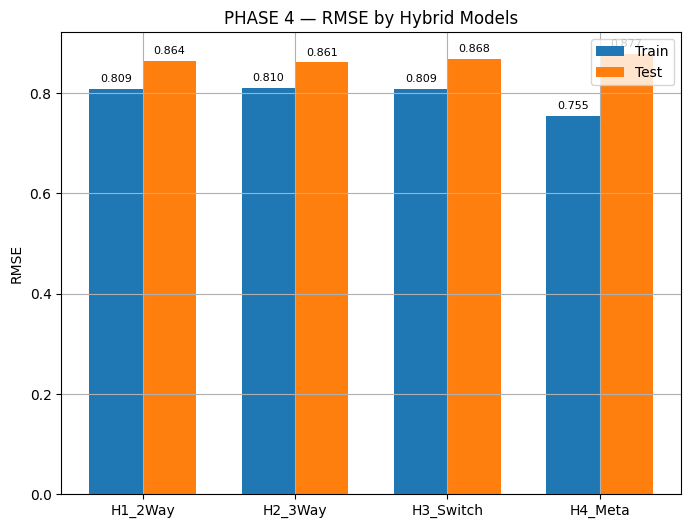

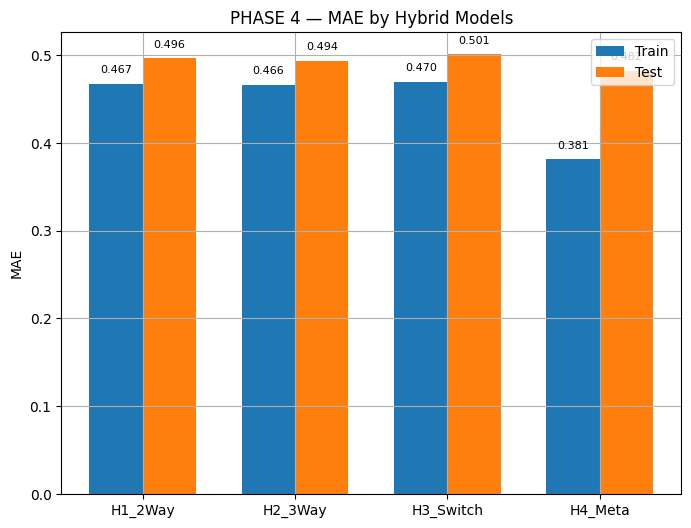

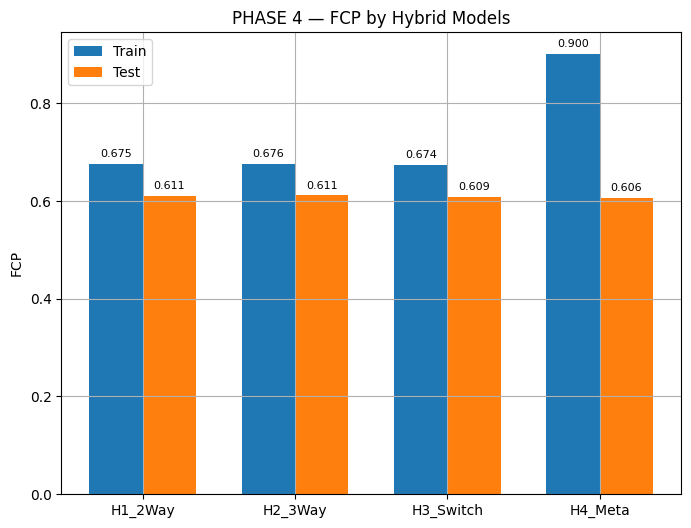

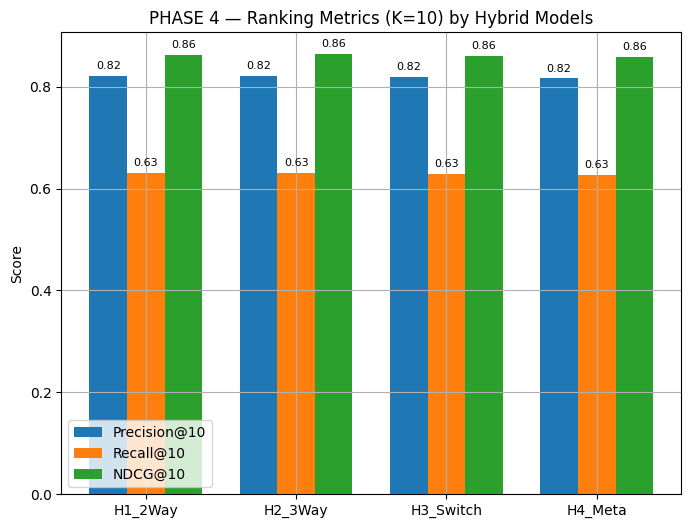

In [37]:
import matplotlib.pyplot as plt
import numpy as np

hybrid_names = ["H1_2Way", "H2_3Way", "H3_Switch", "H4_Meta"]
x = np.arange(len(hybrid_names))
width = 0.35

rmse_train_vals = [hy1_rmse_train, hy2_rmse_train, hy3_rmse_train, hy4_rmse_train]
rmse_test_vals  = [hy1_rmse_test,  hy2_rmse_test,  hy3_rmse_test,  hy4_rmse_test]

mae_train_vals  = [hy1_mae_train, hy2_mae_train, hy3_mae_train, hy4_mae_train]
mae_test_vals   = [hy1_mae_test,  hy2_mae_test,  hy3_mae_test,  hy4_mae_test]

fcp_train_vals  = [hy1_fcp_train, hy2_fcp_train, hy3_fcp_train, hy4_fcp_train]
fcp_test_vals   = [hy1_fcp_test,  hy2_fcp_test,  hy3_fcp_test,  hy4_fcp_test]

prec_vals = [hy1_prec10, hy2_prec10, hy3_prec10, hy4_prec10]
rec_vals  = [hy1_rec10,  hy2_rec10,  hy3_rec10,  hy4_rec10]
ndcg_vals = [hy1_ndcg10, hy2_ndcg10, hy3_ndcg10, hy4_ndcg10]

# RMSE
plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_train_vals, width, label="Train")
plt.bar(x + width/2, rmse_test_vals,  width, label="Test")
for i in range(len(hybrid_names)):
    plt.text(x[i] - width/2, rmse_train_vals[i] + 0.01, f"{rmse_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, rmse_test_vals[i] + 0.01, f"{rmse_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, hybrid_names)
plt.ylabel("RMSE")
plt.title("PHASE 4 — RMSE by Hybrid Models")
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(8,6))
plt.bar(x - width/2, mae_train_vals, width, label="Train")
plt.bar(x + width/2, mae_test_vals,  width, label="Test")
for i in range(len(hybrid_names)):
    plt.text(x[i] - width/2, mae_train_vals[i] + 0.01, f"{mae_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, mae_test_vals[i] + 0.01, f"{mae_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, hybrid_names)
plt.ylabel("MAE")
plt.title("PHASE 4 — MAE by Hybrid Models")
plt.legend()
plt.show()

#  FCP
plt.figure(figsize=(8,6))
plt.bar(x - width/2, fcp_train_vals, width, label="Train")
plt.bar(x + width/2, fcp_test_vals,  width, label="Test")
for i in range(len(hybrid_names)):
    plt.text(x[i] - width/2, fcp_train_vals[i] + 0.01, f"{fcp_train_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, fcp_test_vals[i] + 0.01, f"{fcp_test_vals[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
plt.xticks(x, hybrid_names)
plt.ylabel("FCP")
plt.title("PHASE 4 — FCP by Hybrid Models")
plt.legend()
plt.show()

# Ranking metrics
bar_w = 0.25
plt.figure(figsize=(8,6))
plt.bar(x - bar_w, prec_vals, bar_w, label="Precision@10")
plt.bar(x,         rec_vals,  bar_w, label="Recall@10")
plt.bar(x + bar_w, ndcg_vals, bar_w, label="NDCG@10")

for i in range(len(hybrid_names)):
    plt.text(x[i] - bar_w, prec_vals[i] + 0.01, f"{prec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i],         rec_vals[i]  + 0.01, f"{rec_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + bar_w, ndcg_vals[i] + 0.01, f"{ndcg_vals[i]:.2f}",
             ha="center", va="bottom", fontsize=8)

plt.xticks(x, hybrid_names)
plt.ylabel("Score")
plt.title("PHASE 4 — Ranking Metrics (K=10) by Hybrid Models")
plt.legend()
plt.show()


In [38]:

# PHASE 4 — Ranking Curves
# Precision@K, Recall@K, NDCG@K

K_VALUES = [1, 5, 10, 20, 50]

def compute_curve_metrics(preds, name):
    """Compute ranking metrics for different K values."""
    precs, recs, ndcgs = [], [], []
    for k in K_VALUES:
        p, r, n = ranking_metrics_at_k_local(test_df, preds, k=k, rel_th=5)
        precs.append(p)
        recs.append(r)
        ndcgs.append(n)
    return {
        "name": name,
        "prec": precs,
        "rec": recs,
        "ndcg": ndcgs
    }

# Compute curves for all Hybrid models
hybrid_curves = [
    compute_curve_metrics(hy1_test_pred, "H1_2Way"),
    compute_curve_metrics(hy2_test_pred, "H2_3Way"),
    compute_curve_metrics(hy3_test_pred, "H3_Switch"),
    compute_curve_metrics(hy4_test_pred, "H4_Meta"),
]

print("Computed ranking curves for models:", [c["name"] for c in hybrid_curves])


Computed ranking curves for models: ['H1_2Way', 'H2_3Way', 'H3_Switch', 'H4_Meta']


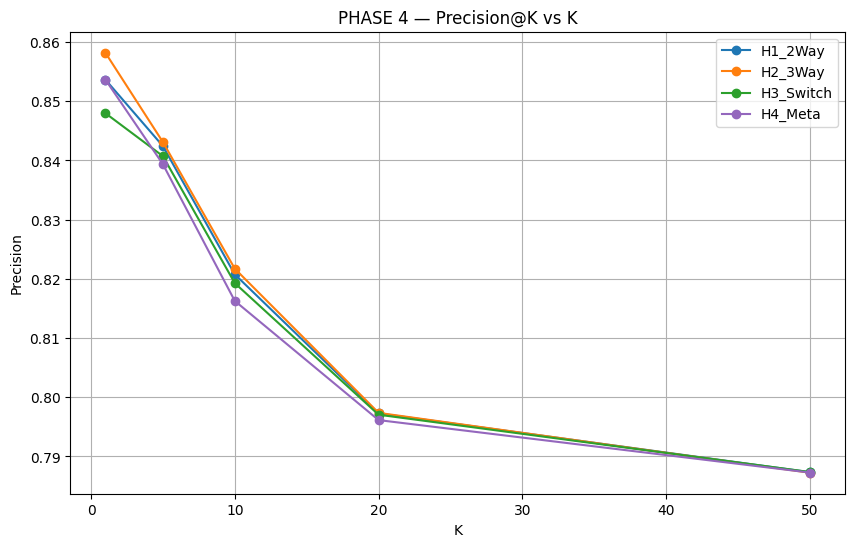

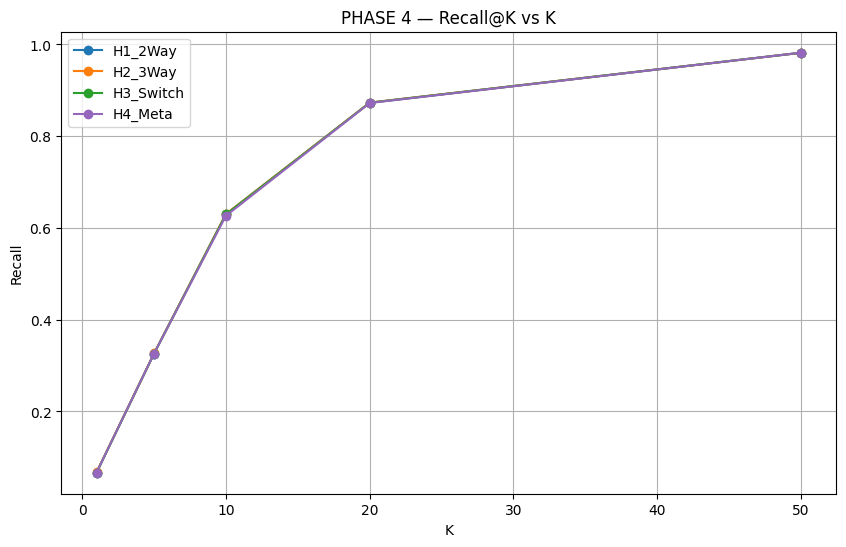

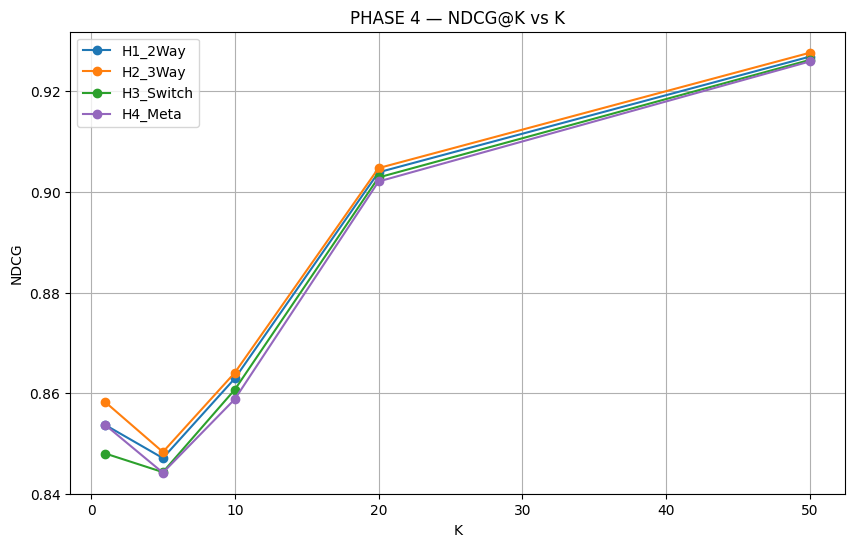

In [39]:

# PHASE 4 — Ranking Curves plots

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]  # one color per model

# Precision@K vs K

plt.figure(figsize=(10,6))
for curve, c in zip(hybrid_curves, colors):
    plt.plot(K_VALUES, curve["prec"], marker="o", label=curve["name"], color=c)
plt.xlabel("K")
plt.ylabel("Precision")
plt.title("PHASE 4 — Precision@K vs K")
plt.legend()
plt.grid(True)
plt.show()


# Recall@K vs K

plt.figure(figsize=(10,6))
for curve, c in zip(hybrid_curves, colors):
    plt.plot(K_VALUES, curve["rec"], marker="o", label=curve["name"], color=c)
plt.xlabel("K")
plt.ylabel("Recall")
plt.title("PHASE 4 — Recall@K vs K")
plt.legend()
plt.grid(True)
plt.show()


#  NDCG@K vs K

plt.figure(figsize=(10,6))
for curve, c in zip(hybrid_curves, colors):
    plt.plot(K_VALUES, curve["ndcg"], marker="o", label=curve["name"], color=c)
plt.xlabel("K")
plt.ylabel("NDCG")
plt.title("PHASE 4 — NDCG@K vs K")
plt.legend()
plt.grid(True)
plt.show()


all model graphs

In [40]:

print("Preparing metrics for all models...")

#  Base models
model_predictions = {
    "CBF": cbf_main_test.astype(np.float32),
    "ItemCF": itemcf_test_pred.astype(np.float32),
    "MF": mf_test_pred.astype(np.float32),
    "PMF": pmf_test_pred.astype(np.float32),
}

# Hybrid models
model_predictions.update({
    "H1_2Way": hy1_test_pred.astype(np.float32),
    "H2_3Way": hy2_test_pred.astype(np.float32),
    "H3_Switch": hy3_test_pred.astype(np.float32),
    "H4_Meta": hy4_test_pred.astype(np.float32),
})

MODEL_NAMES = list(model_predictions.keys())

# Build metric table
rmse_vals = {}
mae_vals = {}
fcp_vals = {}

K_VALUES = [1, 5, 10, 20, 50]
ranking_curves = {}

for name, preds in model_predictions.items():
    # RMSE, MAE, FCP
    rmse_vals[name] = rmse(y_test, preds)
    mae_vals[name]  = mae(y_test, preds)
    fcp_vals[name]  = fcp_local(test_df, preds)

    # Ranking curves
    precs, recs, ndcgs = [], [], []
    for k in K_VALUES:
        p, r, n = ranking_metrics_at_k_local(test_df, preds, k=k, rel_th=5)
        precs.append(p)
        recs.append(r)
        ndcgs.append(n)

    ranking_curves[name] = {
        "prec": precs,
        "rec": recs,
        "ndcg": ndcgs
    }

print("Metrics prepared for models:", MODEL_NAMES)


Preparing metrics for all models...
Metrics prepared for models: ['CBF', 'ItemCF', 'MF', 'PMF', 'H1_2Way', 'H2_3Way', 'H3_Switch', 'H4_Meta']


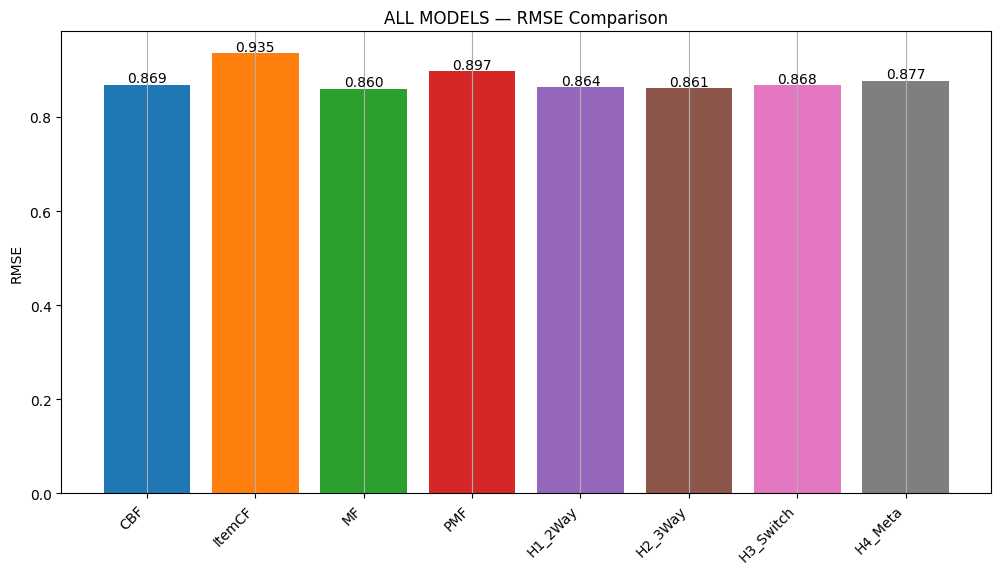

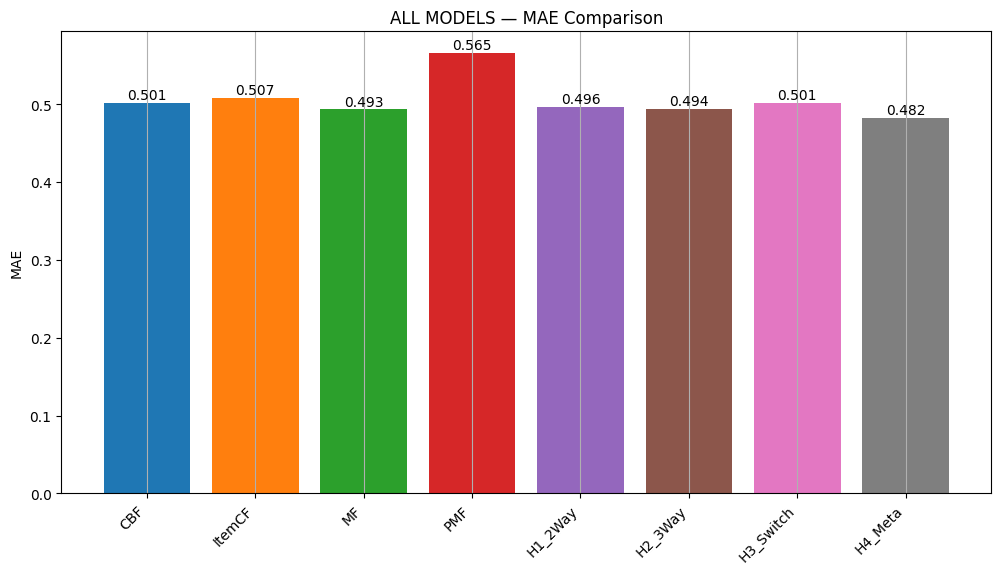

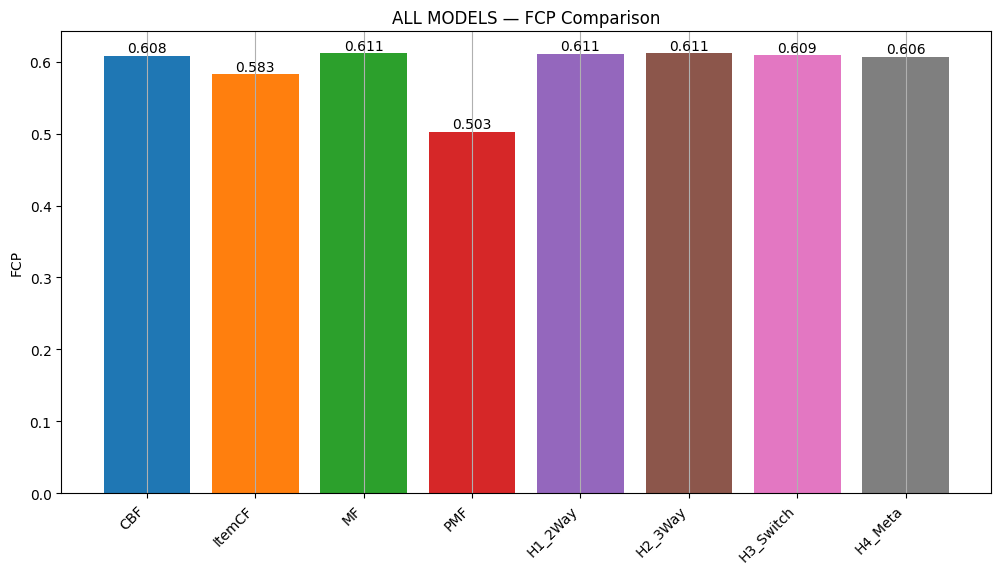

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# consistent model order
names = MODEL_NAMES
x = np.arange(len(names))

colors = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f"
]

#  RMSE
plt.figure(figsize=(12,6))
vals = [rmse_vals[n] for n in names]
plt.bar(x, vals, color=colors)
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("ALL MODELS — RMSE Comparison")
for i,v in enumerate(vals):
    plt.text(i, v+0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y")
plt.show()

#  MAE
plt.figure(figsize=(12,6))
vals = [mae_vals[n] for n in names]
plt.bar(x, vals, color=colors)
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("MAE")
plt.title("ALL MODELS — MAE Comparison")
for i,v in enumerate(vals):
    plt.text(i, v+0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y")
plt.show()

# FCP
plt.figure(figsize=(12,6))
vals = [fcp_vals[n] for n in names]
plt.bar(x, vals, color=colors)
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("FCP")
plt.title("ALL MODELS — FCP Comparison")
for i,v in enumerate(vals):
    plt.text(i, v+0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y")
plt.show()


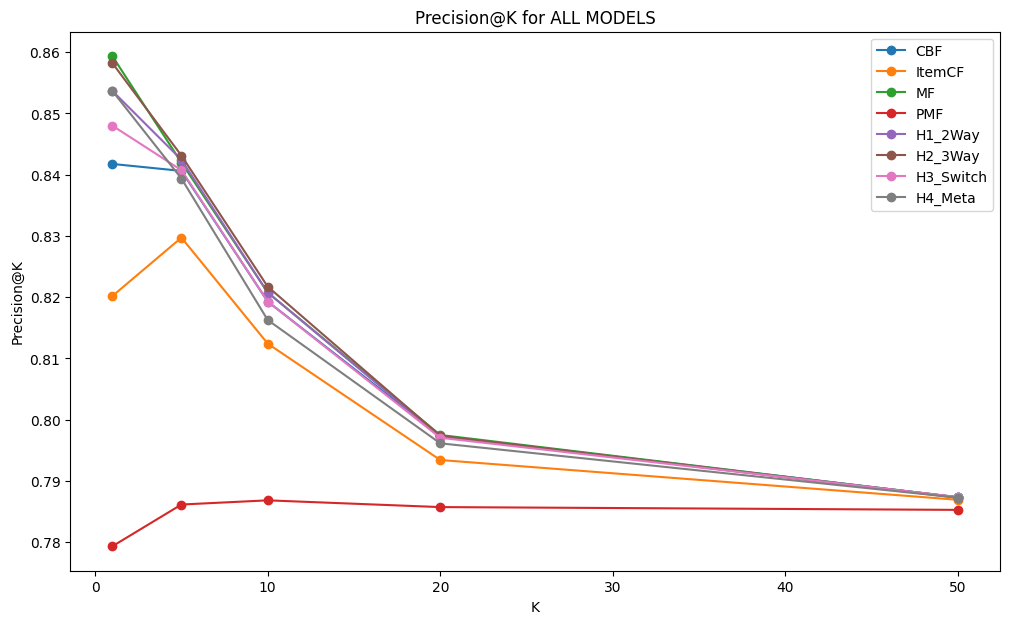

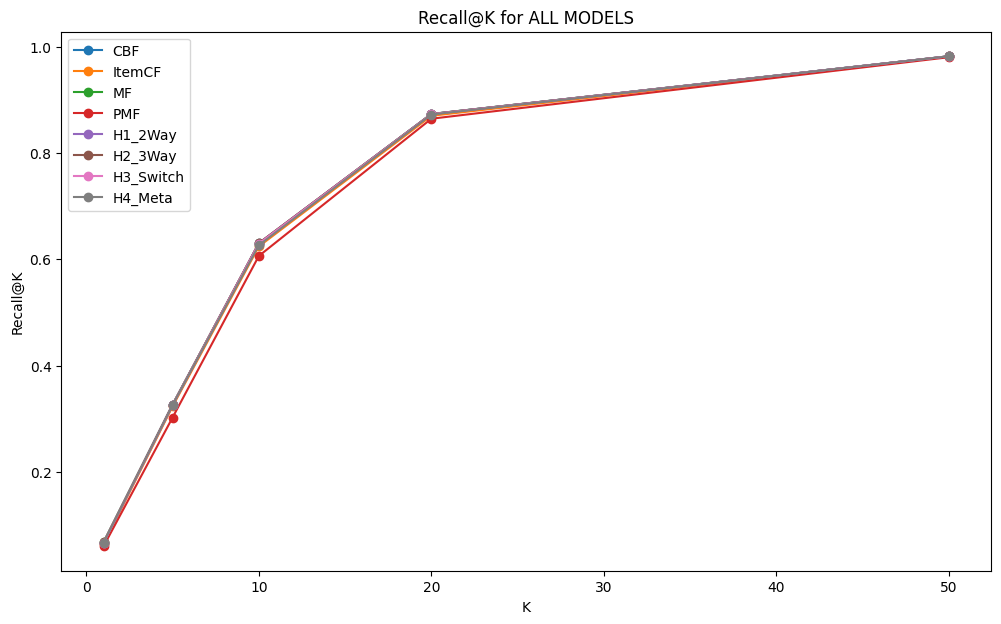

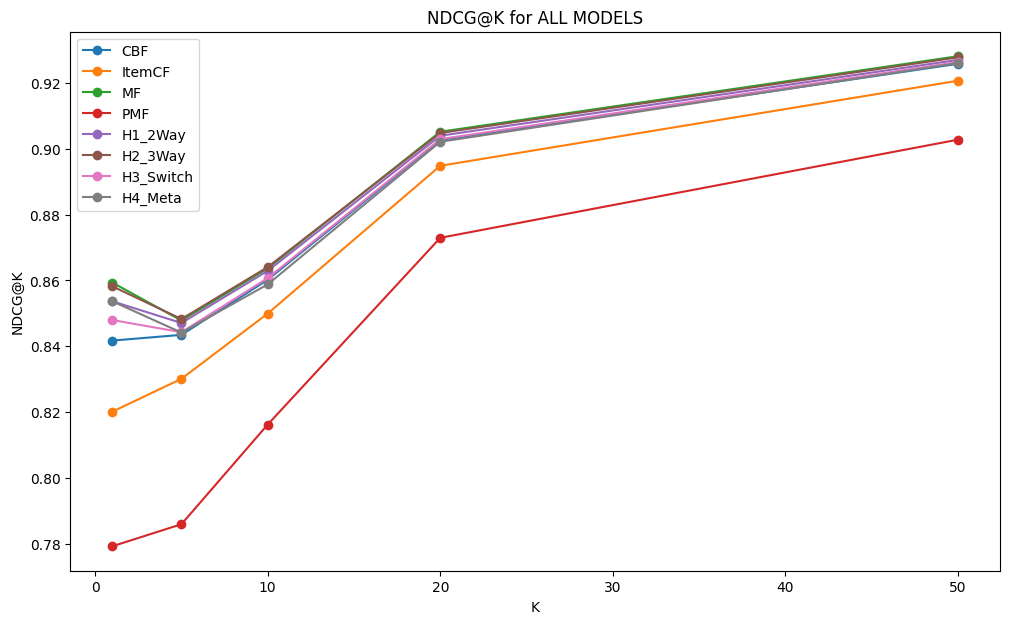

In [42]:
plt.figure(figsize=(12,7))
for name, c in zip(names, colors):
    plt.plot(K_VALUES, ranking_curves[name]["prec"], marker="o", label=name, color=c)

plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title("Precision@K for ALL MODELS")
plt.legend()
plt.grid()
plt.show()

#  Recall@K
plt.figure(figsize=(12,7))
for name, c in zip(names, colors):
    plt.plot(K_VALUES, ranking_curves[name]["rec"], marker="o", label=name, color=c)

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K for ALL MODELS")
plt.legend()
plt.grid()
plt.show()

# NDCG@K
plt.figure(figsize=(12,7))
for name, c in zip(names, colors):
    plt.plot(K_VALUES, ranking_curves[name]["ndcg"], marker="o", label=name, color=c)

plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.title("NDCG@K for ALL MODELS")
plt.legend()
plt.grid()
plt.show()

